**Импортируем библиотеки**

In [3]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import pathlib

## Некоторые картинки

There are 7394 all pictures.


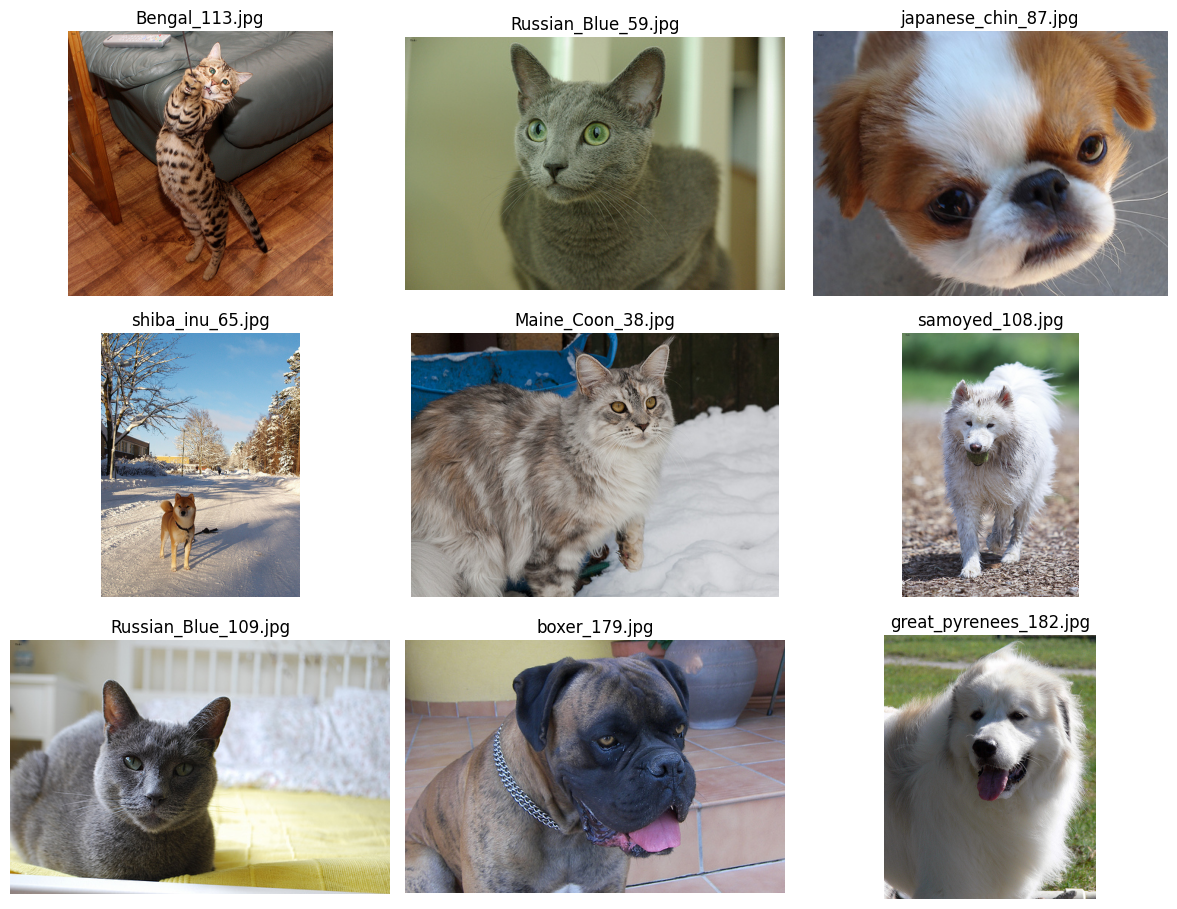

In [6]:
PATH = 'images/'
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} all pictures.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Предварительная обработка изображений


In [7]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_dir = pathlib.Path('images')

train_data = datasets.ImageFolder('images', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)


imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


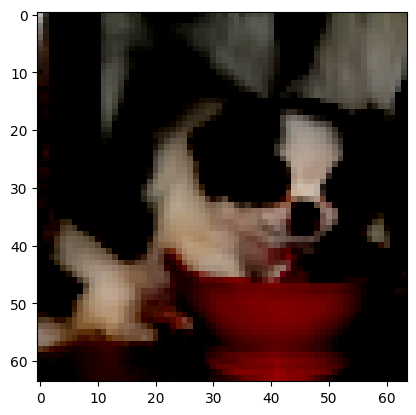

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


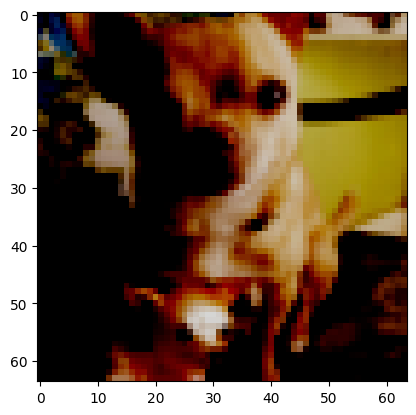

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


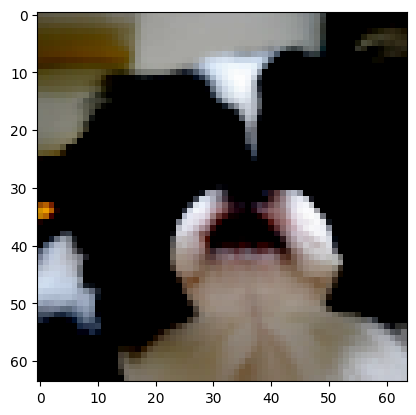

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


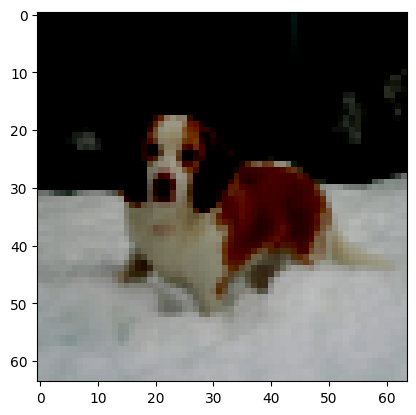

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


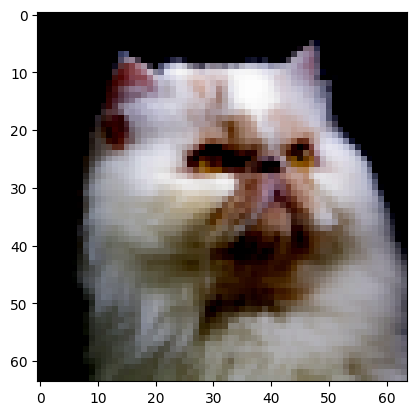

In [8]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

## Weights
### Определим функцию инициализации весов

In [9]:
def weights_init(m): #Принимает на вход нейронную сеть m и инициализирует все её веса.
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Определение Генератора

In [10]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

#Создание генератора
netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Определение Дискриминатора

In [11]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1)
    
    
#Создание дискриминатора
netD = D()
netD.apply(weights_init)


D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Допонительная установка

In [12]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0),
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False), 
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

# Обучение

In [13]:
EPOCH = 20
LR = 0.001
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

In [48]:
for epoch in range(EPOCH):
    for i, data in enumerate(train_loader, 0):
        #1.Обновление весов нейронной сети дискриминатора
        netD.zero_grad()
        
        #Обучение дискриминатора на реальном фото
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output, target)
        
        #Обучение дискриминатора на фото, сгенерированном генератором
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        #2. Обновление весов нейронной сети генератора
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        #3. Вывод потерь и сохранение реальных и сгенерированных фото каждые 100 шагов
        print(f'Epoch {epoch + 1}/{EPOCH}, Step {i + 1}/{len(train_loader)}, Loss_D: {errD.item():.4f}, Loss_G: {errG.item():.4f}')
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize=True)

Epoch 1/20, Step 1/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 2/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 3/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 4/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 5/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 6/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 7/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 8/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 9/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 10/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 11/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 12/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 13/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 14/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 15/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 16/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 17/231, Loss_D: 100.0000, Loss_G: 0.0000
Epoch 1/20, Step 18/231

### Параметры обучения

In [50]:
batch_size = 32
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 50

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Инициализируем модель и оптимизаторы

In [51]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

**Метод построения графика потерь за эпоху**

In [52]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

**Метод для показа сгенерированных изображений**

In [53]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

### Тренировочный цикл

 50%|████▉     | 115/231 [02:26<02:29,  1.29s/it]

[1/50][115/231] Loss_D: 1.0506 Loss_G: 2.4321 D(x): 0.5529 D(G(z)): 0.3120 / 0.0739


100%|█████████▉| 230/231 [04:39<00:00,  1.08it/s]

[1/50][230/231] Loss_D: 1.4127 Loss_G: 1.1848 D(x): 0.4369 D(G(z)): 0.3905 / 0.3092


100%|██████████| 231/231 [04:40<00:00,  1.21s/it]


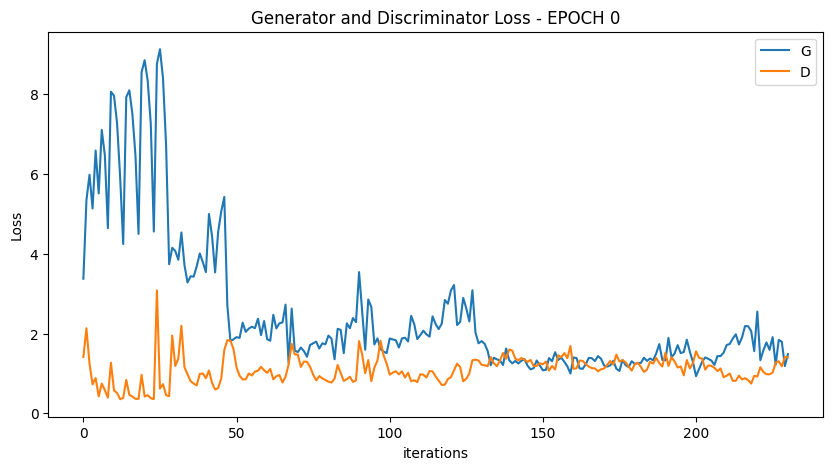

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


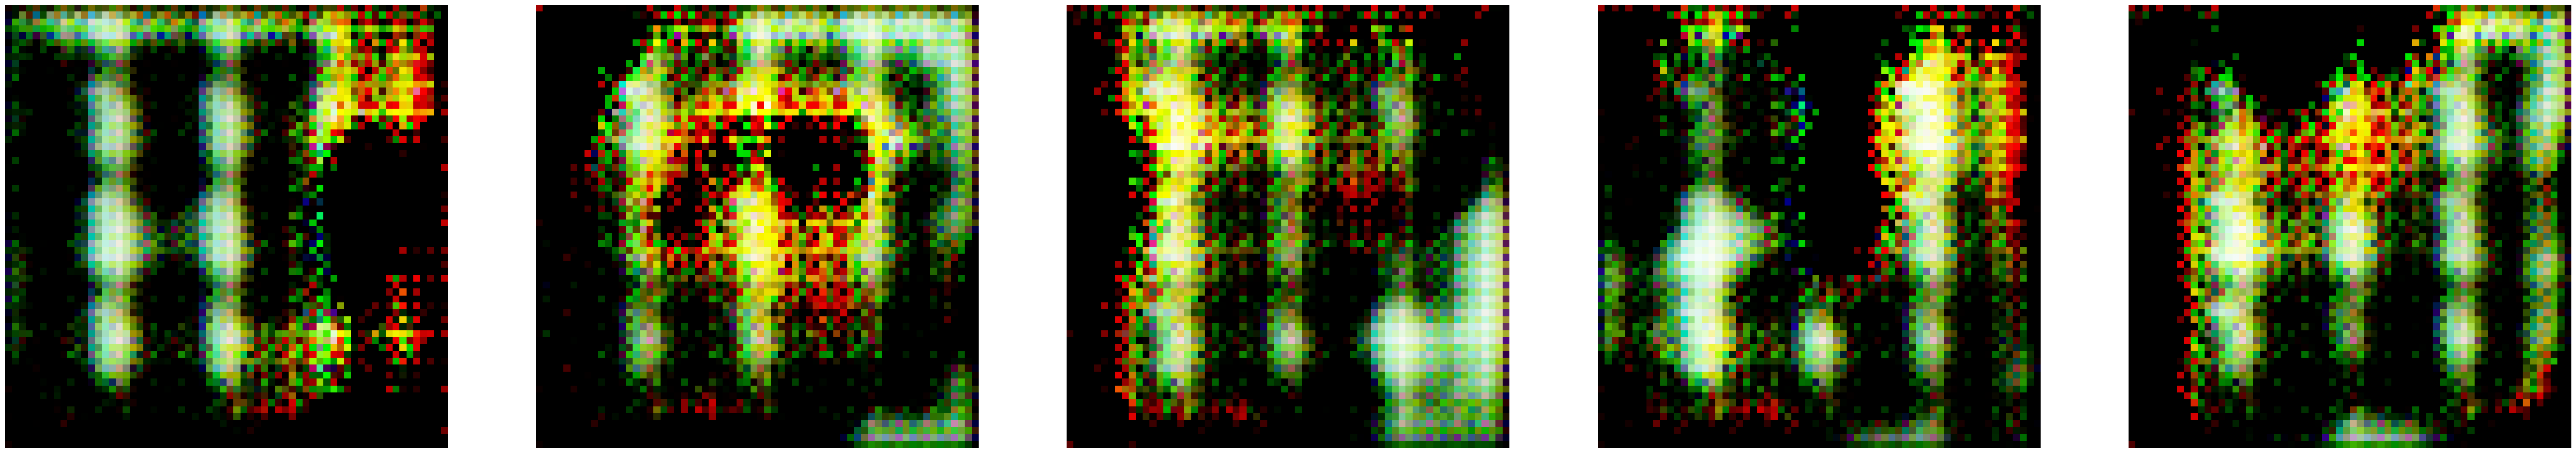

 50%|████▉     | 115/231 [01:50<01:48,  1.07it/s]

[2/50][115/231] Loss_D: 1.4647 Loss_G: 1.0508 D(x): 0.4174 D(G(z)): 0.4107 / 0.3454


100%|█████████▉| 230/231 [03:47<00:01,  1.04s/it]

[2/50][230/231] Loss_D: 1.2733 Loss_G: 1.0501 D(x): 0.4722 D(G(z)): 0.3846 / 0.3426


100%|██████████| 231/231 [03:48<00:00,  1.01it/s]


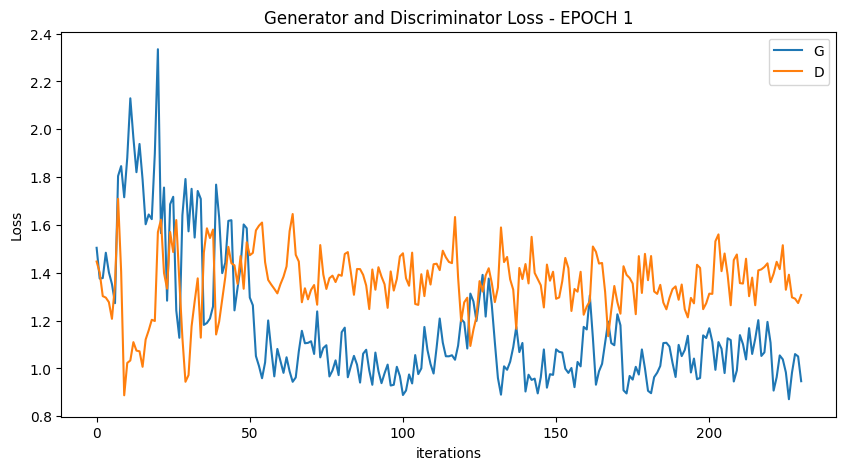

 50%|████▉     | 115/231 [01:54<02:01,  1.04s/it]

[3/50][115/231] Loss_D: 1.0312 Loss_G: 1.5060 D(x): 0.5772 D(G(z)): 0.3225 / 0.2094


100%|█████████▉| 230/231 [03:51<00:01,  1.02s/it]

[3/50][230/231] Loss_D: 1.5571 Loss_G: 0.9116 D(x): 0.4212 D(G(z)): 0.4701 / 0.3960


100%|██████████| 231/231 [03:52<00:00,  1.00s/it]


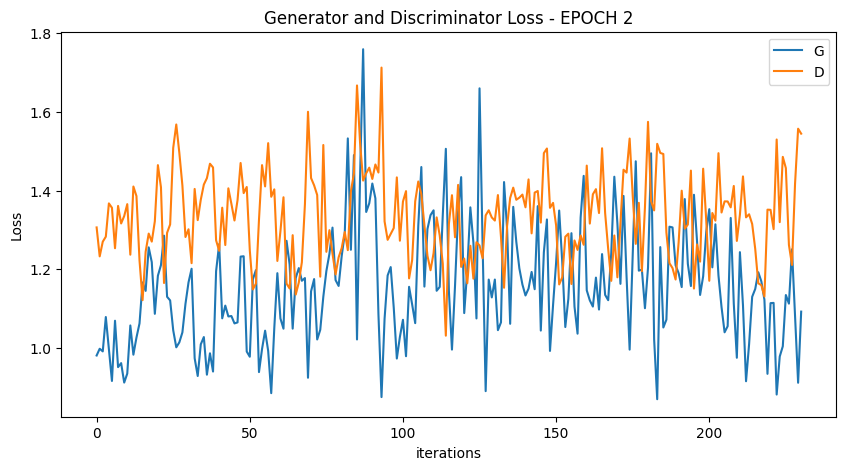

 50%|████▉     | 115/231 [01:47<01:45,  1.10it/s]

[4/50][115/231] Loss_D: 1.5713 Loss_G: 1.2738 D(x): 0.4558 D(G(z)): 0.5087 / 0.2724


100%|█████████▉| 230/231 [03:37<00:00,  1.03it/s]

[4/50][230/231] Loss_D: 1.1905 Loss_G: 1.3492 D(x): 0.5395 D(G(z)): 0.4001 / 0.2482


100%|██████████| 231/231 [03:38<00:00,  1.06it/s]


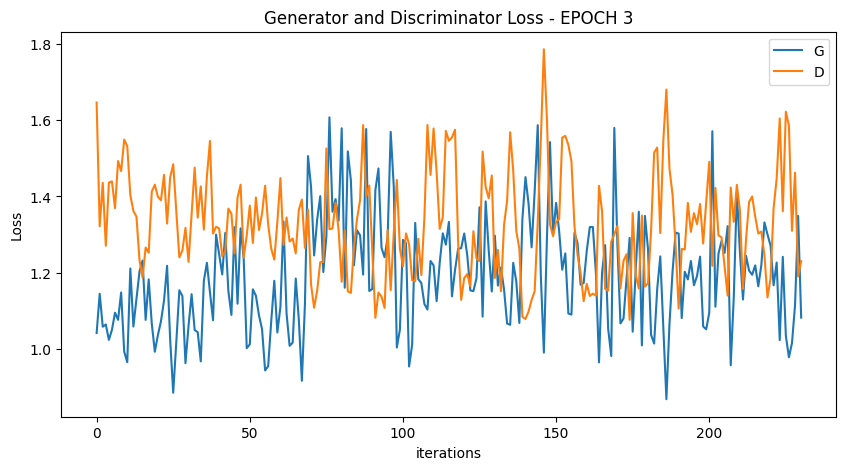

 50%|████▉     | 115/231 [01:46<01:51,  1.04it/s]

[5/50][115/231] Loss_D: 1.4314 Loss_G: 1.4057 D(x): 0.4712 D(G(z)): 0.4680 / 0.2234


100%|█████████▉| 230/231 [03:34<00:00,  1.09it/s]

[5/50][230/231] Loss_D: 1.1820 Loss_G: 1.2093 D(x): 0.4941 D(G(z)): 0.3286 / 0.2939


100%|██████████| 231/231 [03:35<00:00,  1.07it/s]


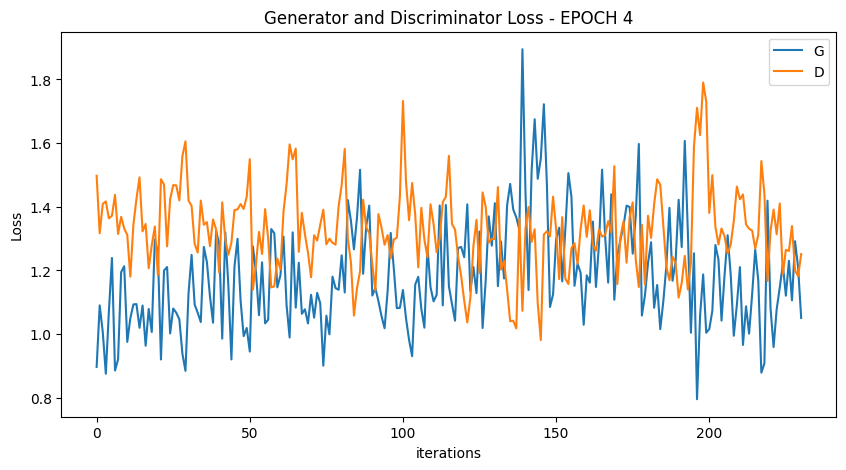

 50%|████▉     | 115/231 [01:47<01:44,  1.11it/s]

[6/50][115/231] Loss_D: 1.4096 Loss_G: 1.1433 D(x): 0.3742 D(G(z)): 0.3133 / 0.3074


100%|█████████▉| 230/231 [03:32<00:00,  1.10it/s]

[6/50][230/231] Loss_D: 1.4146 Loss_G: 1.6679 D(x): 0.4538 D(G(z)): 0.4204 / 0.1788


100%|██████████| 231/231 [03:33<00:00,  1.08it/s]


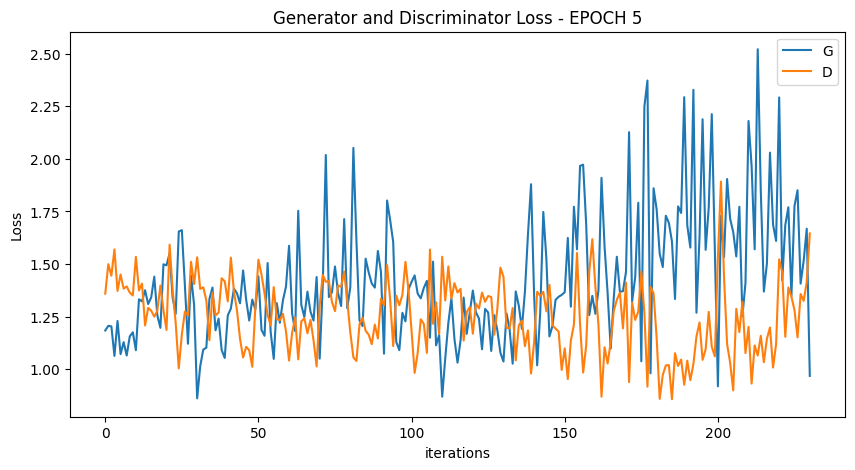

 50%|████▉     | 115/231 [01:48<01:49,  1.06it/s]

[7/50][115/231] Loss_D: 1.0107 Loss_G: 1.9345 D(x): 0.6046 D(G(z)): 0.3418 / 0.1266


100%|█████████▉| 230/231 [03:35<00:00,  1.07it/s]

[7/50][230/231] Loss_D: 1.3645 Loss_G: 1.2657 D(x): 0.3813 D(G(z)): 0.2899 / 0.2783


100%|██████████| 231/231 [03:36<00:00,  1.07it/s]


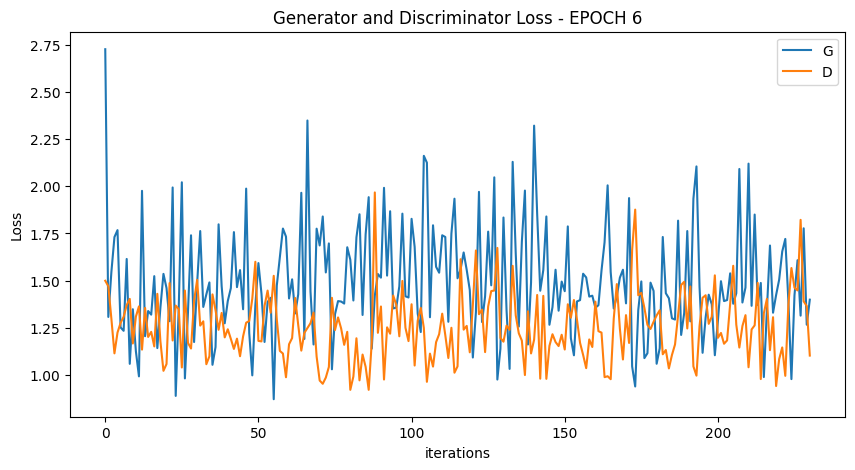

 50%|████▉     | 115/231 [01:47<01:46,  1.09it/s]

[8/50][115/231] Loss_D: 1.1687 Loss_G: 1.9708 D(x): 0.5688 D(G(z)): 0.3851 / 0.1251


100%|█████████▉| 230/231 [03:33<00:00,  1.11it/s]

[8/50][230/231] Loss_D: 1.3139 Loss_G: 1.2444 D(x): 0.5191 D(G(z)): 0.4545 / 0.2757


100%|██████████| 231/231 [03:33<00:00,  1.08it/s]


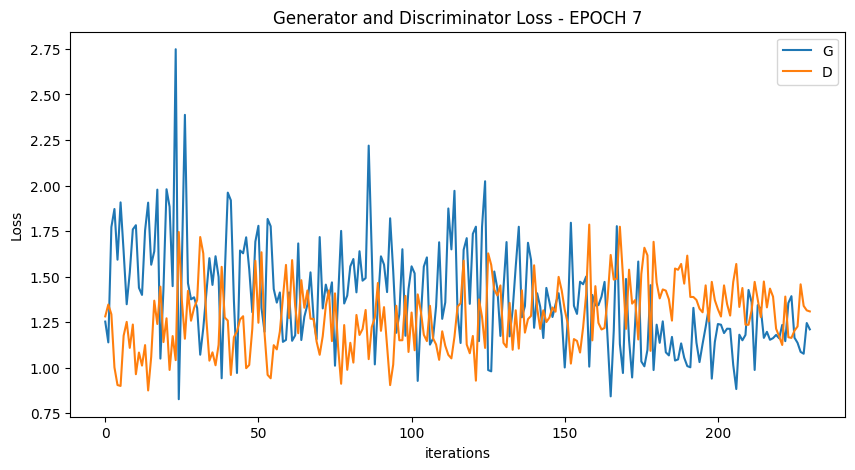

 50%|████▉     | 115/231 [01:46<01:43,  1.12it/s]

[9/50][115/231] Loss_D: 1.4259 Loss_G: 0.9348 D(x): 0.3557 D(G(z)): 0.3360 / 0.3903


100%|█████████▉| 230/231 [03:33<00:01,  1.03s/it]

[9/50][230/231] Loss_D: 1.5701 Loss_G: 0.9447 D(x): 0.3970 D(G(z)): 0.4602 / 0.3822


100%|██████████| 231/231 [03:35<00:00,  1.07it/s]


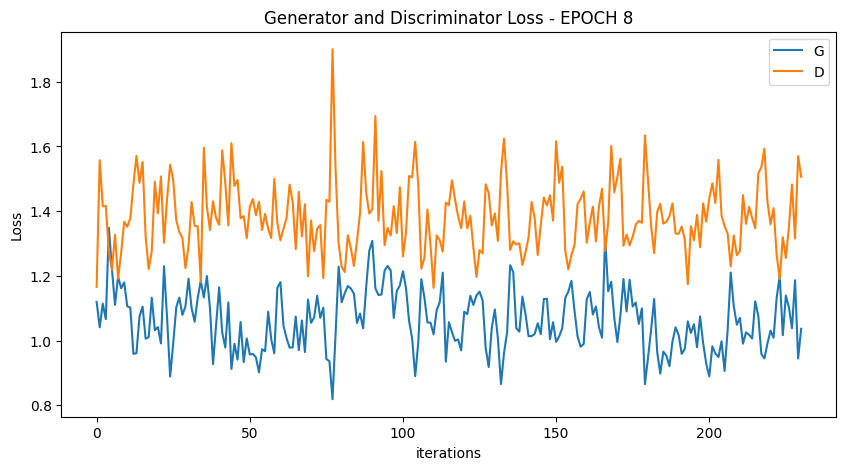

 50%|████▉     | 115/231 [01:48<01:43,  1.12it/s]

[10/50][115/231] Loss_D: 1.4799 Loss_G: 1.0082 D(x): 0.4201 D(G(z)): 0.4375 / 0.3585


100%|█████████▉| 230/231 [03:34<00:00,  1.01it/s]

[10/50][230/231] Loss_D: 1.4934 Loss_G: 0.8974 D(x): 0.3929 D(G(z)): 0.4127 / 0.3988


100%|██████████| 231/231 [03:35<00:00,  1.07it/s]


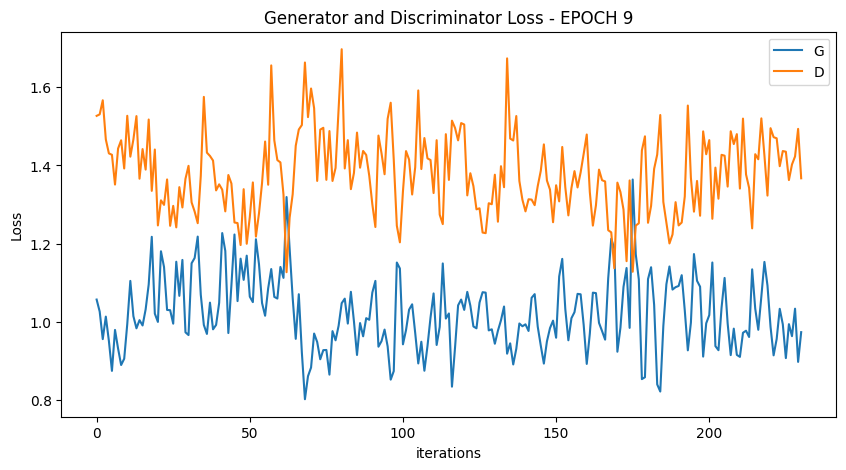

 50%|████▉     | 115/231 [01:45<01:43,  1.12it/s]

[11/50][115/231] Loss_D: 1.4741 Loss_G: 0.8924 D(x): 0.4998 D(G(z)): 0.5152 / 0.4037


100%|█████████▉| 230/231 [03:34<00:00,  1.07it/s]

[11/50][230/231] Loss_D: 1.2403 Loss_G: 1.1212 D(x): 0.5280 D(G(z)): 0.4145 / 0.3151


100%|██████████| 231/231 [03:35<00:00,  1.07it/s]


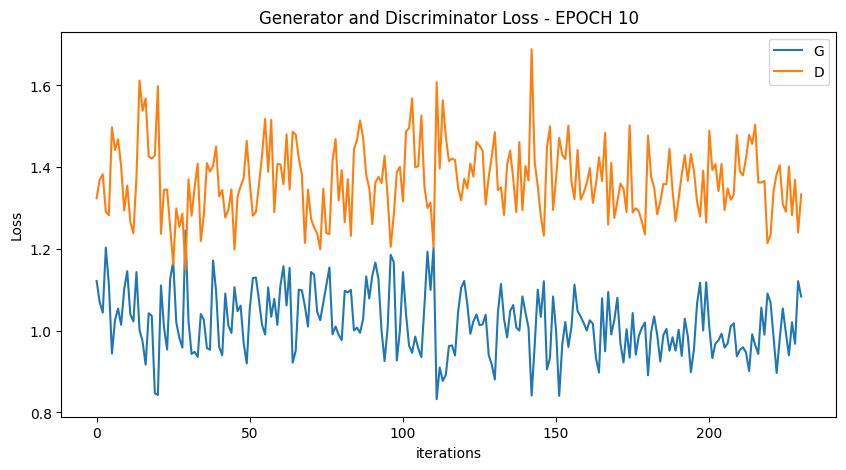

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


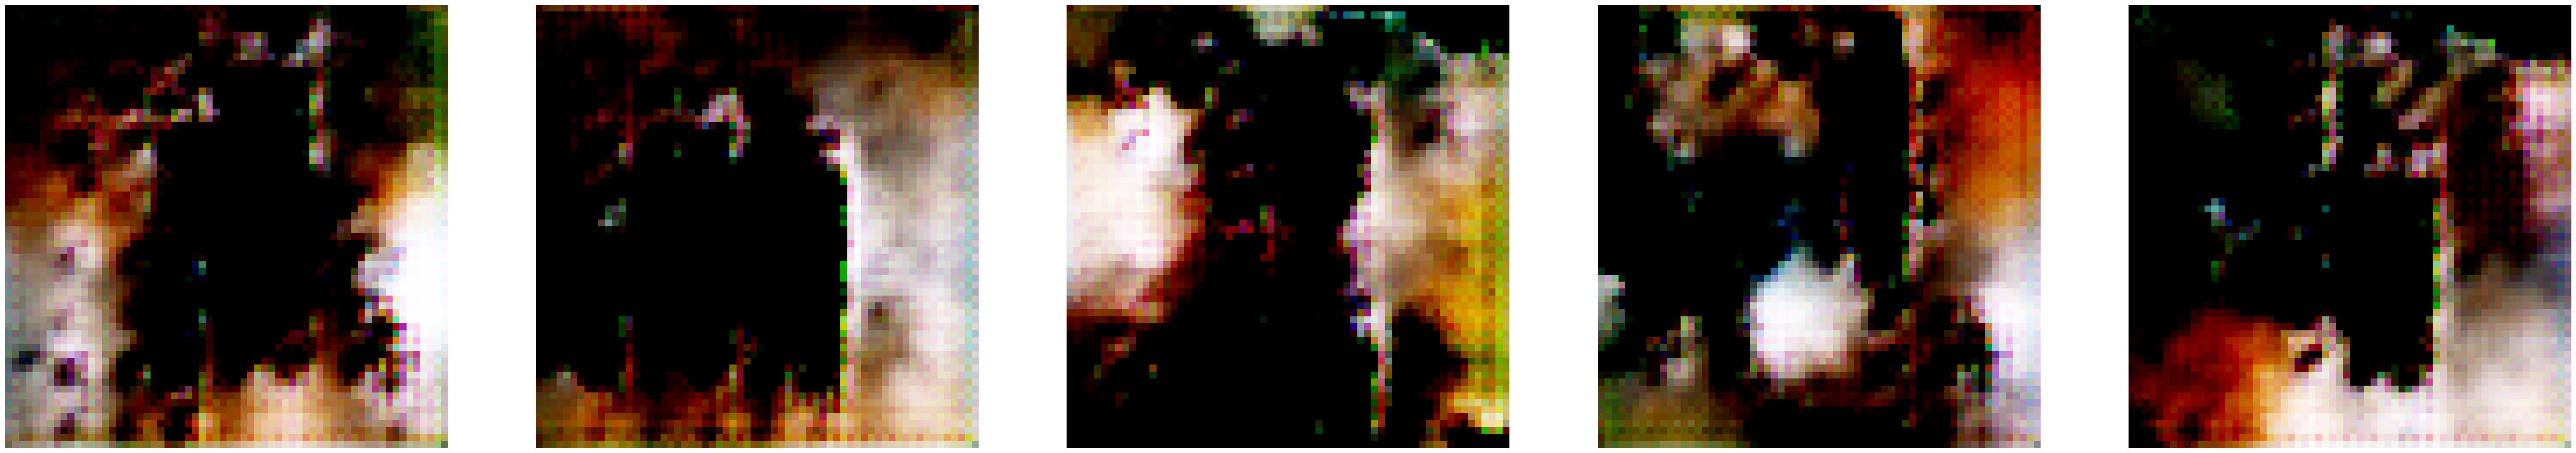

 50%|████▉     | 115/231 [01:48<01:44,  1.11it/s]

[12/50][115/231] Loss_D: 1.4912 Loss_G: 1.0241 D(x): 0.4102 D(G(z)): 0.4313 / 0.3449


100%|█████████▉| 230/231 [03:34<00:00,  1.10it/s]

[12/50][230/231] Loss_D: 1.3756 Loss_G: 1.0355 D(x): 0.4888 D(G(z)): 0.4577 / 0.3432


100%|██████████| 231/231 [03:35<00:00,  1.07it/s]


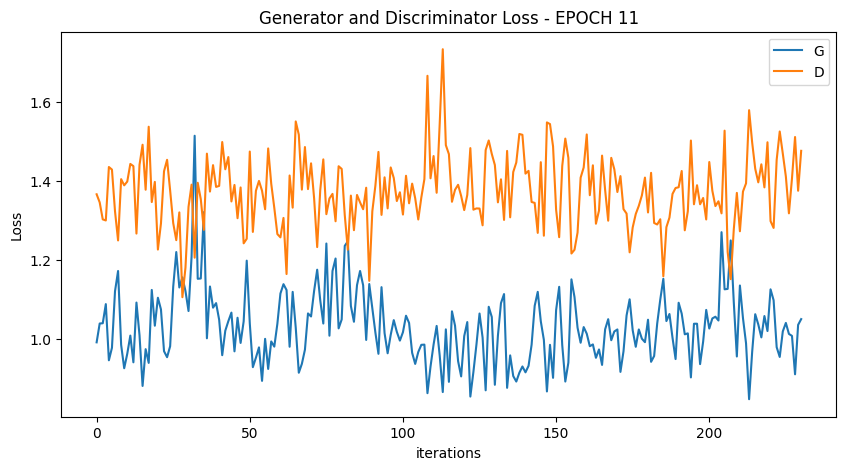

 50%|████▉     | 115/231 [01:45<01:42,  1.13it/s]

[13/50][115/231] Loss_D: 1.3975 Loss_G: 1.1821 D(x): 0.5219 D(G(z)): 0.4889 / 0.2967


100%|█████████▉| 230/231 [03:33<00:00,  1.12it/s]

[13/50][230/231] Loss_D: 1.3971 Loss_G: 1.0258 D(x): 0.4666 D(G(z)): 0.4405 / 0.3520


100%|██████████| 231/231 [03:34<00:00,  1.08it/s]


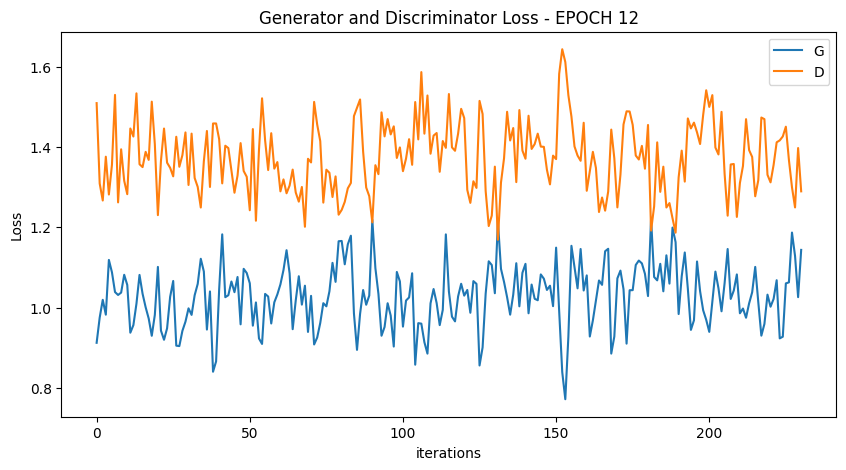

 50%|████▉     | 115/231 [01:48<01:49,  1.06it/s]

[14/50][115/231] Loss_D: 1.3073 Loss_G: 1.0813 D(x): 0.4949 D(G(z)): 0.4359 / 0.3228


100%|█████████▉| 230/231 [03:36<00:00,  1.10it/s]

[14/50][230/231] Loss_D: 1.2855 Loss_G: 1.0042 D(x): 0.5052 D(G(z)): 0.4339 / 0.3549


100%|██████████| 231/231 [03:36<00:00,  1.06it/s]


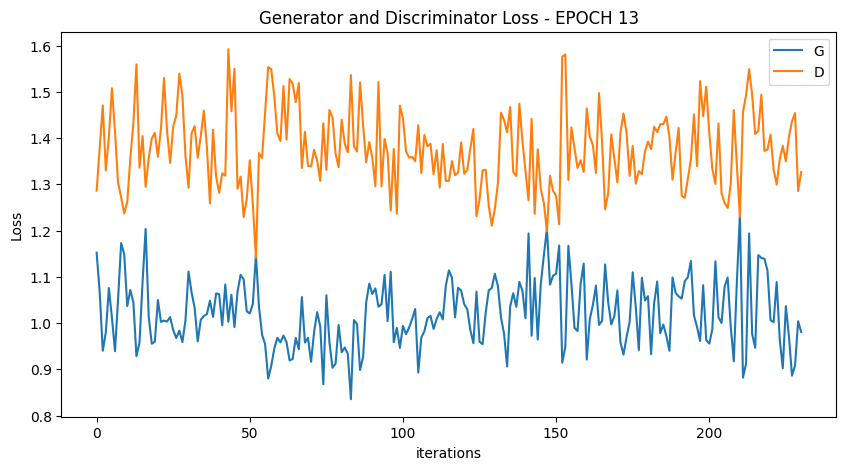

 50%|████▉     | 115/231 [01:46<01:42,  1.13it/s]

[15/50][115/231] Loss_D: 1.3720 Loss_G: 1.0041 D(x): 0.4552 D(G(z)): 0.4089 / 0.3656


100%|█████████▉| 230/231 [03:37<00:00,  1.08it/s]

[15/50][230/231] Loss_D: 1.4159 Loss_G: 1.0354 D(x): 0.4506 D(G(z)): 0.4358 / 0.3479


100%|██████████| 231/231 [03:38<00:00,  1.06it/s]


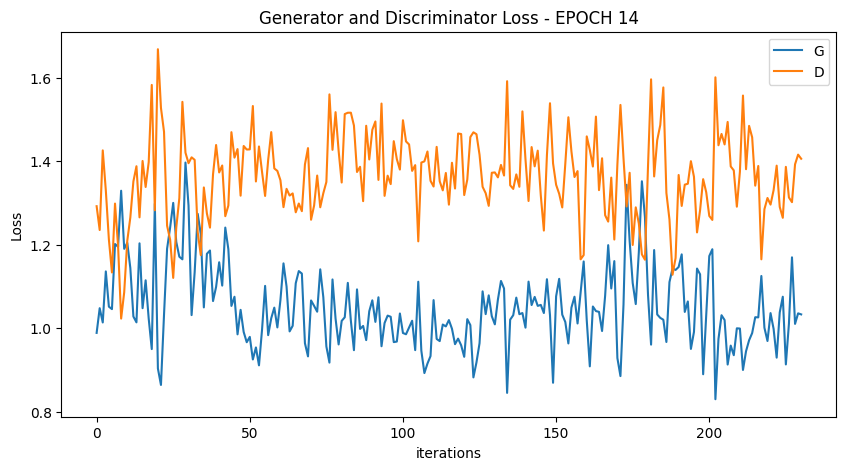

 50%|████▉     | 115/231 [01:47<01:47,  1.08it/s]

[16/50][115/231] Loss_D: 1.4670 Loss_G: 0.9463 D(x): 0.4388 D(G(z)): 0.4638 / 0.3855


100%|█████████▉| 230/231 [03:36<00:00,  1.10it/s]

[16/50][230/231] Loss_D: 1.3235 Loss_G: 0.9554 D(x): 0.4787 D(G(z)): 0.4250 / 0.3724


100%|██████████| 231/231 [03:37<00:00,  1.06it/s]


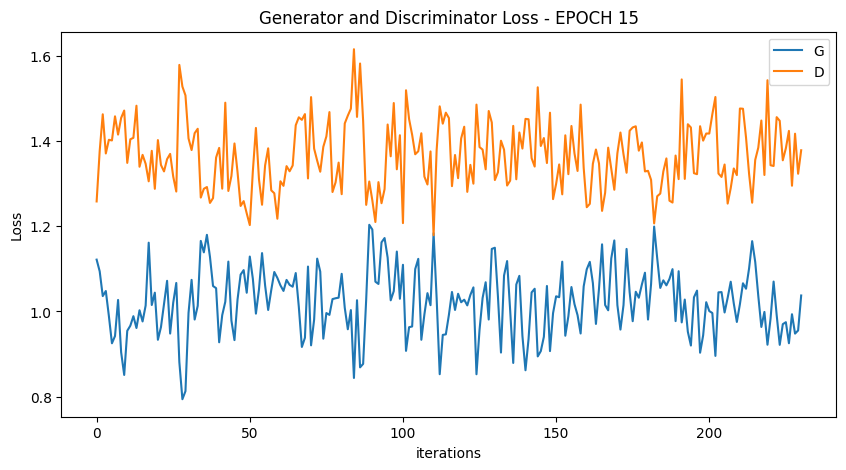

 50%|████▉     | 115/231 [01:48<01:52,  1.03it/s]

[17/50][115/231] Loss_D: 1.5052 Loss_G: 0.8623 D(x): 0.4062 D(G(z)): 0.4532 / 0.4162


100%|█████████▉| 230/231 [03:46<00:01,  1.26s/it]

[17/50][230/231] Loss_D: 1.3098 Loss_G: 0.9665 D(x): 0.4838 D(G(z)): 0.4151 / 0.3700


100%|██████████| 231/231 [03:47<00:00,  1.02it/s]


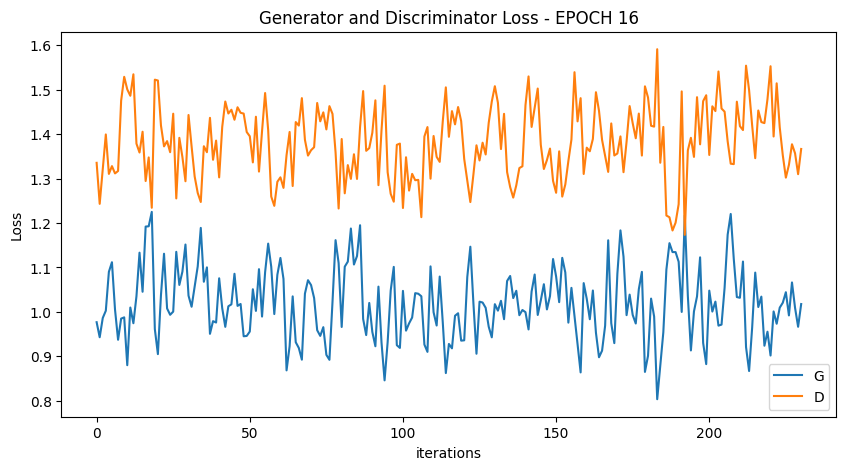

 50%|████▉     | 115/231 [02:55<02:57,  1.53s/it]

[18/50][115/231] Loss_D: 1.4514 Loss_G: 0.9270 D(x): 0.4650 D(G(z)): 0.4832 / 0.3804


100%|█████████▉| 230/231 [05:51<00:01,  1.54s/it]

[18/50][230/231] Loss_D: 1.3073 Loss_G: 1.0063 D(x): 0.5309 D(G(z)): 0.4634 / 0.3561


100%|██████████| 231/231 [05:52<00:00,  1.53s/it]


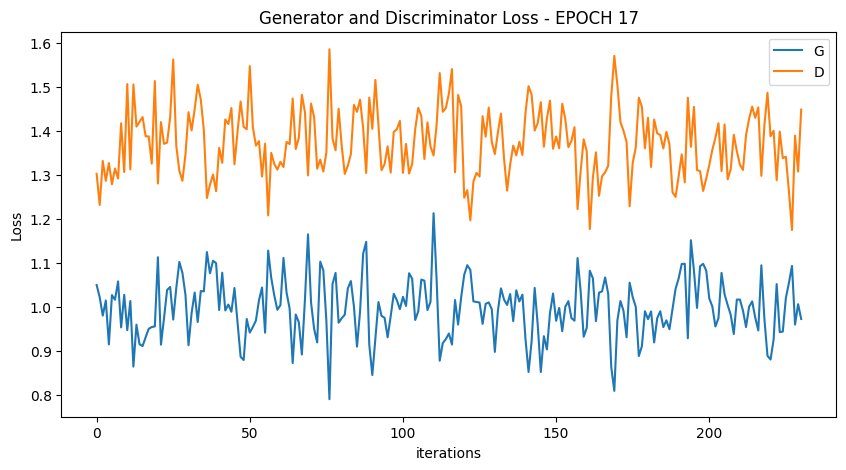

 50%|████▉     | 115/231 [02:57<02:59,  1.54s/it]

[19/50][115/231] Loss_D: 1.3937 Loss_G: 0.9346 D(x): 0.4284 D(G(z)): 0.4232 / 0.3768


100%|█████████▉| 230/231 [05:55<00:01,  1.54s/it]

[19/50][230/231] Loss_D: 1.3269 Loss_G: 1.0084 D(x): 0.4355 D(G(z)): 0.3764 / 0.3494


100%|██████████| 231/231 [05:56<00:00,  1.54s/it]


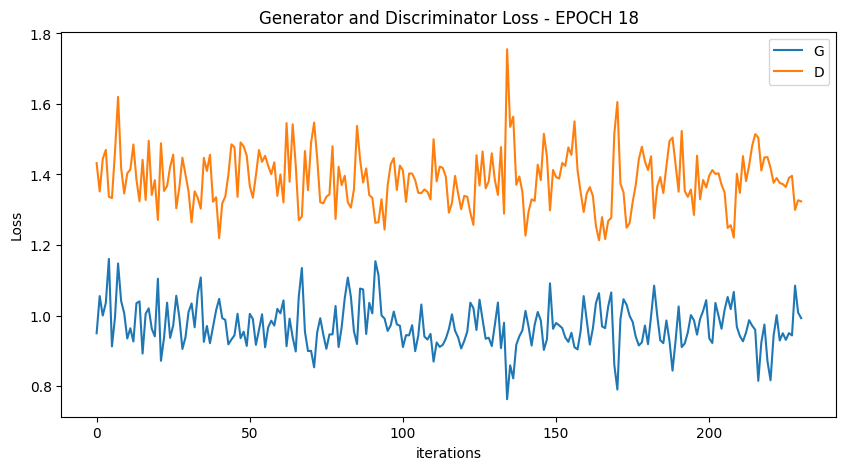

 50%|████▉     | 115/231 [02:56<02:59,  1.54s/it]

[20/50][115/231] Loss_D: 1.3961 Loss_G: 1.0669 D(x): 0.4853 D(G(z)): 0.4707 / 0.3279


100%|█████████▉| 230/231 [05:54<00:01,  1.54s/it]

[20/50][230/231] Loss_D: 1.2270 Loss_G: 1.0837 D(x): 0.5096 D(G(z)): 0.4073 / 0.3206


100%|██████████| 231/231 [05:55<00:00,  1.54s/it]


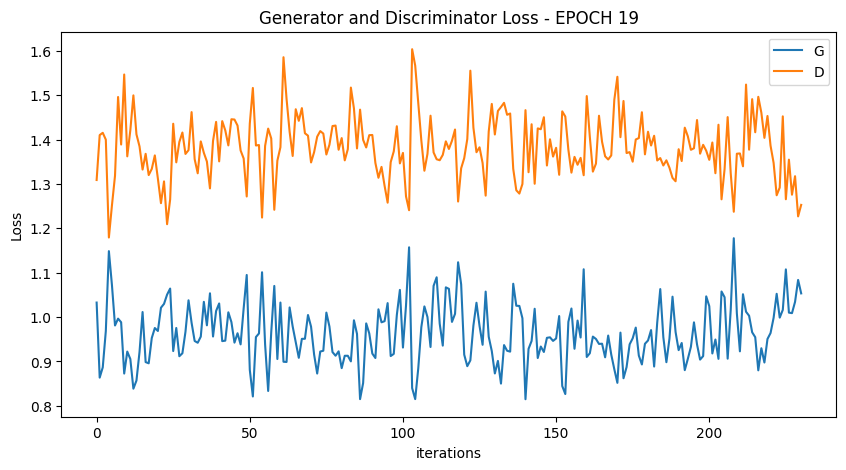

 50%|████▉     | 115/231 [02:55<02:59,  1.55s/it]

[21/50][115/231] Loss_D: 1.4123 Loss_G: 0.8845 D(x): 0.4447 D(G(z)): 0.4482 / 0.4021


100%|█████████▉| 230/231 [05:52<00:01,  1.54s/it]

[21/50][230/231] Loss_D: 1.4817 Loss_G: 1.0674 D(x): 0.3171 D(G(z)): 0.3157 / 0.3272


100%|██████████| 231/231 [05:53<00:00,  1.53s/it]


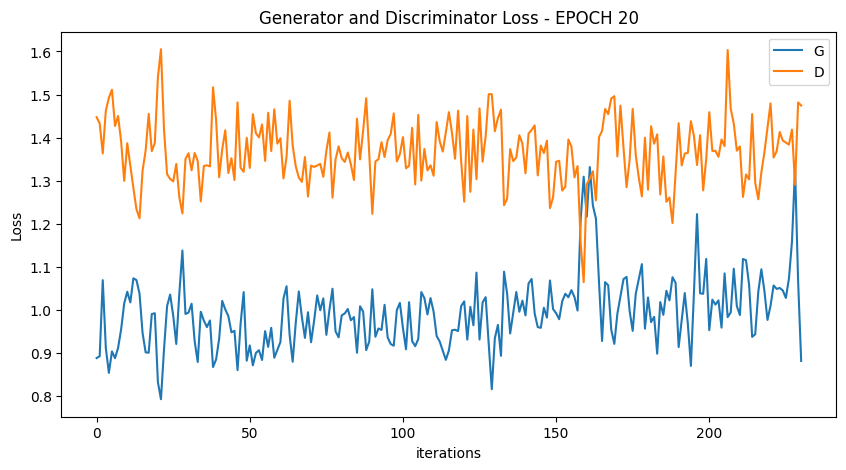

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


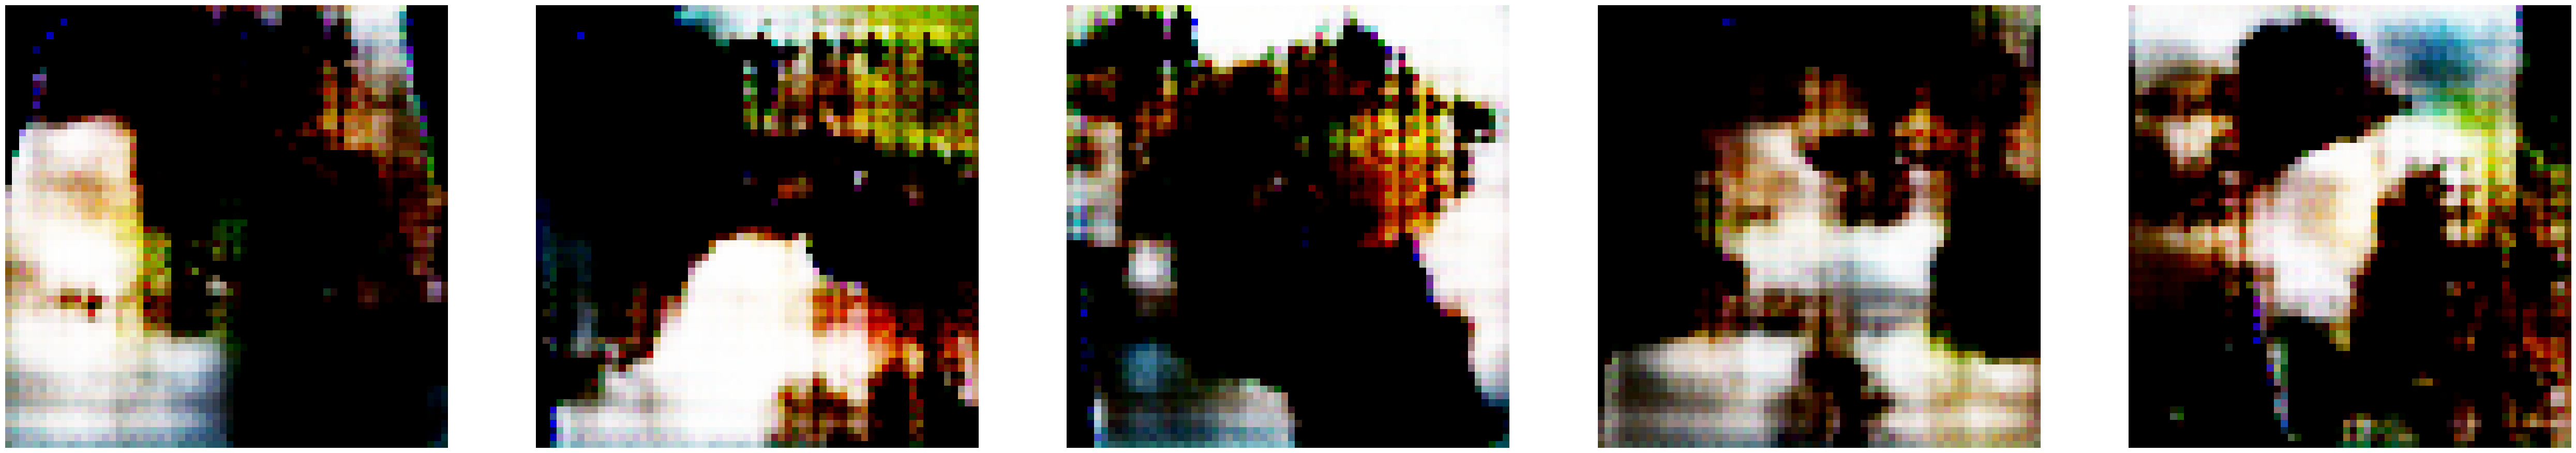

 50%|████▉     | 115/231 [02:56<02:58,  1.54s/it]

[22/50][115/231] Loss_D: 1.3521 Loss_G: 0.8799 D(x): 0.4918 D(G(z)): 0.4588 / 0.4044


100%|█████████▉| 230/231 [05:52<00:01,  1.53s/it]

[22/50][230/231] Loss_D: 1.2912 Loss_G: 1.0546 D(x): 0.4696 D(G(z)): 0.4044 / 0.3376


100%|██████████| 231/231 [05:54<00:00,  1.53s/it]


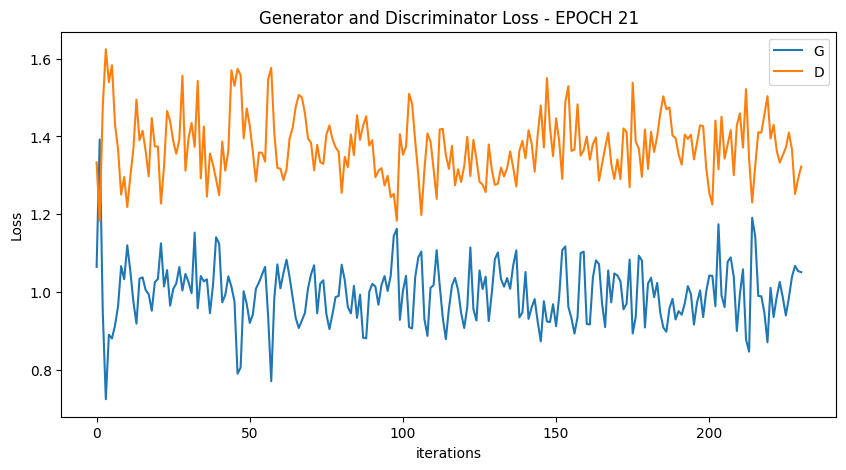

 50%|████▉     | 115/231 [02:56<02:57,  1.53s/it]

[23/50][115/231] Loss_D: 1.3250 Loss_G: 0.9386 D(x): 0.4895 D(G(z)): 0.4434 / 0.3786


100%|█████████▉| 230/231 [05:53<00:01,  1.52s/it]

[23/50][230/231] Loss_D: 1.4496 Loss_G: 0.9297 D(x): 0.4426 D(G(z)): 0.4658 / 0.3850


100%|██████████| 231/231 [05:54<00:00,  1.53s/it]


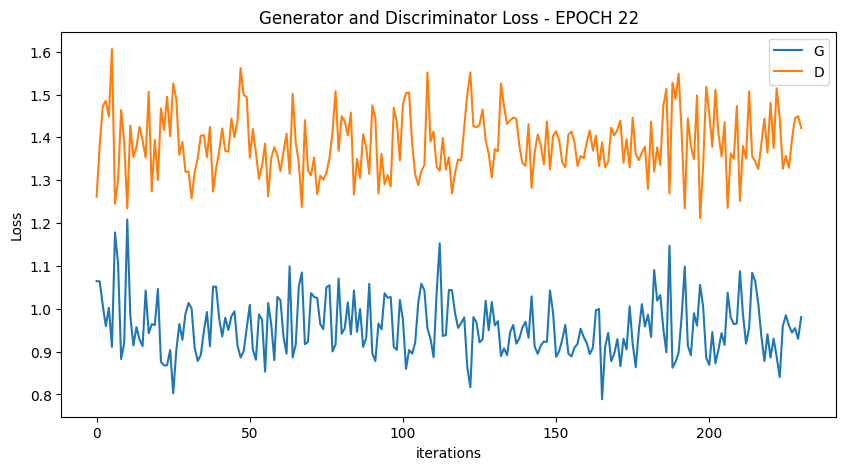

 50%|████▉     | 115/231 [02:55<02:56,  1.52s/it]

[24/50][115/231] Loss_D: 1.3551 Loss_G: 0.9280 D(x): 0.4594 D(G(z)): 0.4309 / 0.3878


100%|█████████▉| 230/231 [05:52<00:01,  1.53s/it]

[24/50][230/231] Loss_D: 1.3684 Loss_G: 0.9421 D(x): 0.5035 D(G(z)): 0.4729 / 0.3779


100%|██████████| 231/231 [05:53<00:00,  1.53s/it]


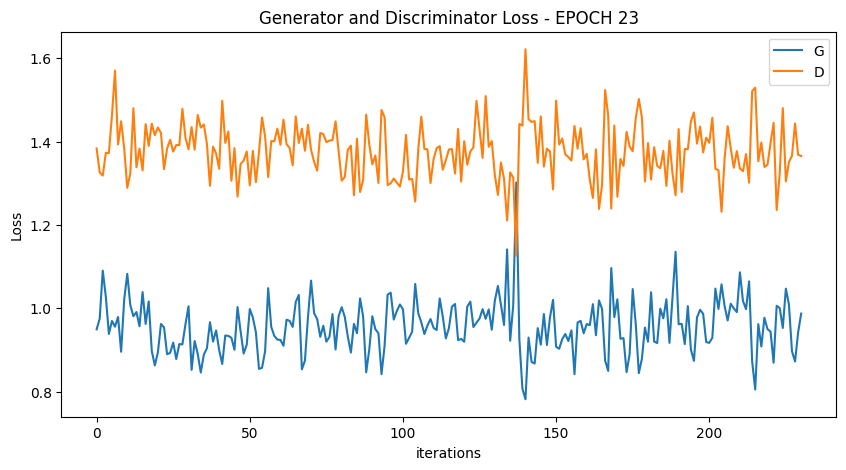

 50%|████▉     | 115/231 [02:57<02:57,  1.53s/it]

[25/50][115/231] Loss_D: 1.3729 Loss_G: 0.9126 D(x): 0.4777 D(G(z)): 0.4597 / 0.3882


100%|█████████▉| 230/231 [05:53<00:01,  1.53s/it]

[25/50][230/231] Loss_D: 1.3948 Loss_G: 0.9696 D(x): 0.4489 D(G(z)): 0.4416 / 0.3638


100%|██████████| 231/231 [05:54<00:00,  1.54s/it]


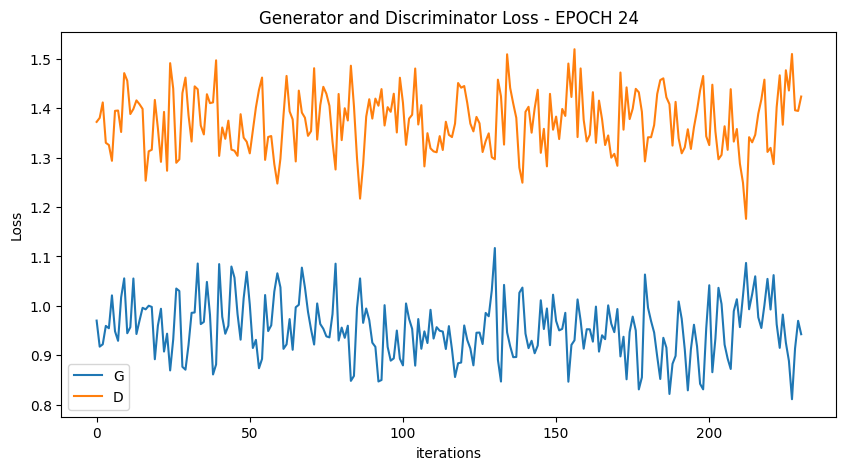

 50%|████▉     | 115/231 [02:56<02:56,  1.52s/it]

[26/50][115/231] Loss_D: 1.3395 Loss_G: 0.9552 D(x): 0.5040 D(G(z)): 0.4631 / 0.3722


100%|█████████▉| 230/231 [05:51<00:01,  1.52s/it]

[26/50][230/231] Loss_D: 1.3321 Loss_G: 1.0163 D(x): 0.4552 D(G(z)): 0.4142 / 0.3421


100%|██████████| 231/231 [05:52<00:00,  1.53s/it]


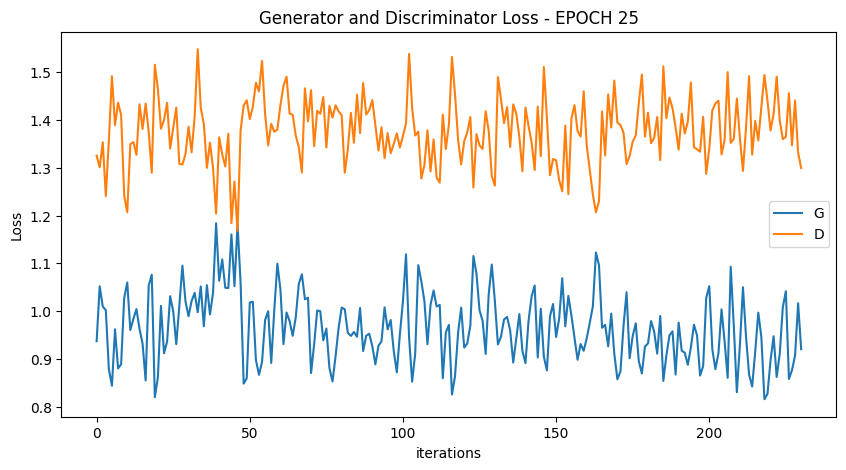

 50%|████▉     | 115/231 [02:53<02:54,  1.50s/it]

[27/50][115/231] Loss_D: 1.4932 Loss_G: 0.8856 D(x): 0.4601 D(G(z)): 0.5007 / 0.4048


100%|█████████▉| 230/231 [05:49<00:01,  1.55s/it]

[27/50][230/231] Loss_D: 1.4095 Loss_G: 0.9803 D(x): 0.4375 D(G(z)): 0.4368 / 0.3690


100%|██████████| 231/231 [05:51<00:00,  1.52s/it]


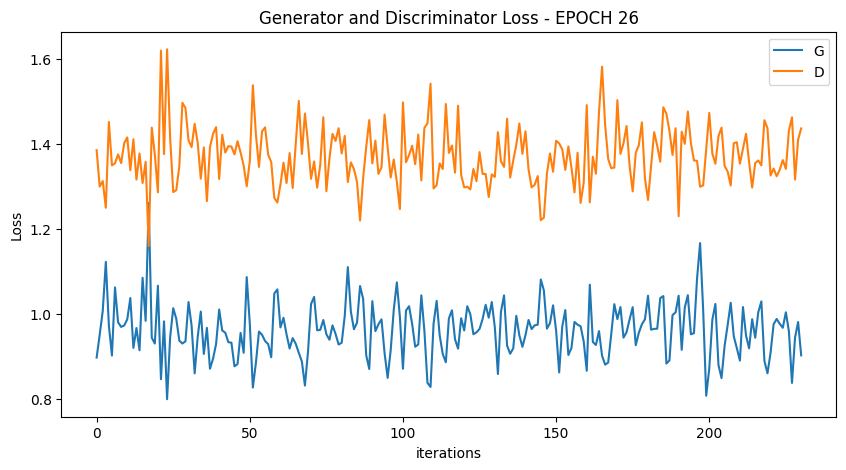

 50%|████▉     | 115/231 [02:56<02:55,  1.52s/it]

[28/50][115/231] Loss_D: 1.2566 Loss_G: 1.0747 D(x): 0.5162 D(G(z)): 0.4228 / 0.3301


100%|█████████▉| 230/231 [05:51<00:01,  1.53s/it]

[28/50][230/231] Loss_D: 1.3482 Loss_G: 1.0432 D(x): 0.4351 D(G(z)): 0.3964 / 0.3357


100%|██████████| 231/231 [05:53<00:00,  1.53s/it]


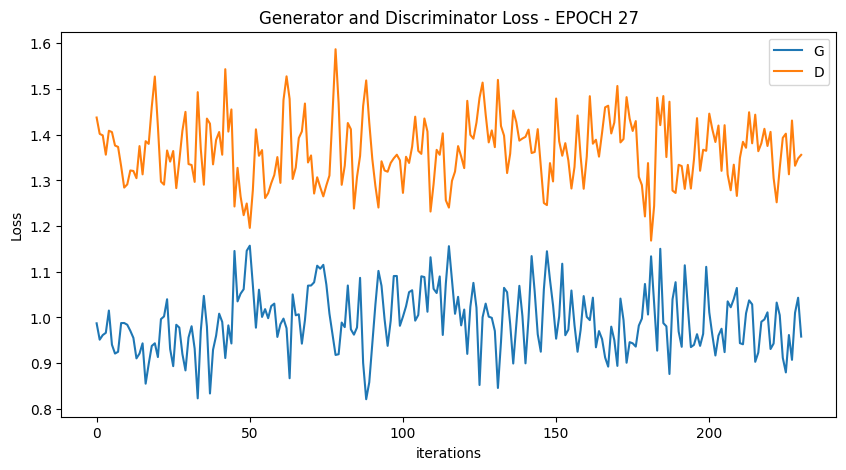

 50%|████▉     | 115/231 [02:57<02:59,  1.55s/it]

[29/50][115/231] Loss_D: 1.3659 Loss_G: 0.9944 D(x): 0.4790 D(G(z)): 0.4493 / 0.3589


100%|█████████▉| 230/231 [05:53<00:01,  1.54s/it]

[29/50][230/231] Loss_D: 1.2403 Loss_G: 1.2366 D(x): 0.5577 D(G(z)): 0.4461 / 0.2687


100%|██████████| 231/231 [05:55<00:00,  1.54s/it]


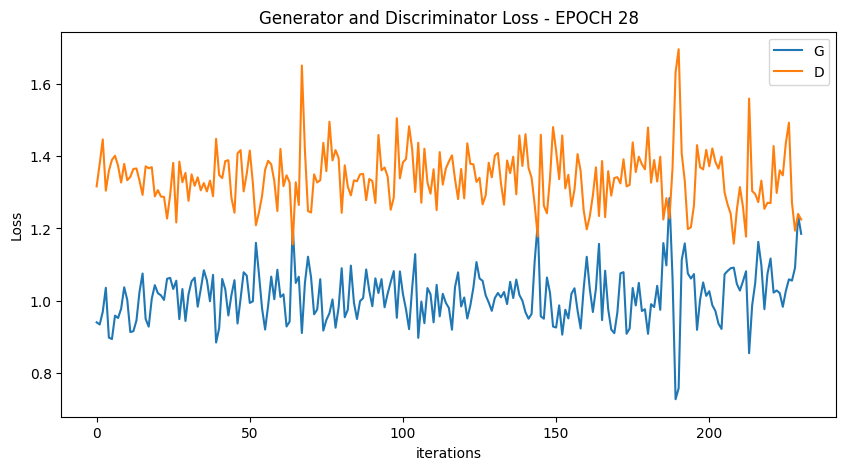

 50%|████▉     | 115/231 [02:54<02:58,  1.54s/it]

[30/50][115/231] Loss_D: 1.3328 Loss_G: 0.9230 D(x): 0.4793 D(G(z)): 0.4309 / 0.3893


100%|█████████▉| 230/231 [05:52<00:01,  1.53s/it]

[30/50][230/231] Loss_D: 1.4831 Loss_G: 1.0203 D(x): 0.4327 D(G(z)): 0.4623 / 0.3504


100%|██████████| 231/231 [05:53<00:00,  1.53s/it]


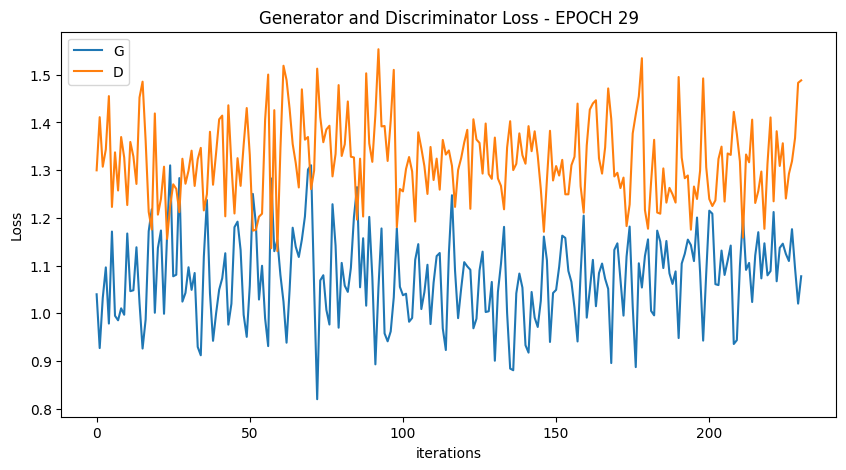

 50%|████▉     | 115/231 [02:57<02:58,  1.54s/it]

[31/50][115/231] Loss_D: 1.3208 Loss_G: 1.4260 D(x): 0.4188 D(G(z)): 0.3378 / 0.2265


100%|█████████▉| 230/231 [05:55<00:01,  1.53s/it]

[31/50][230/231] Loss_D: 1.3672 Loss_G: 1.0401 D(x): 0.4978 D(G(z)): 0.4645 / 0.3408


100%|██████████| 231/231 [05:56<00:00,  1.54s/it]


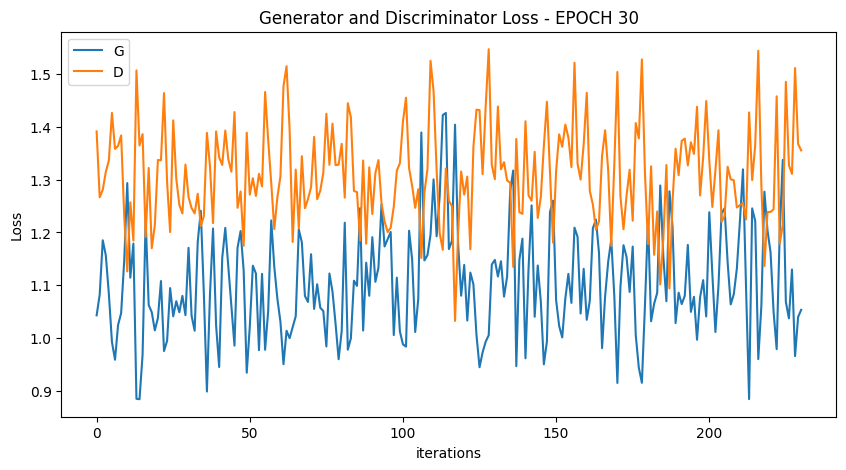

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


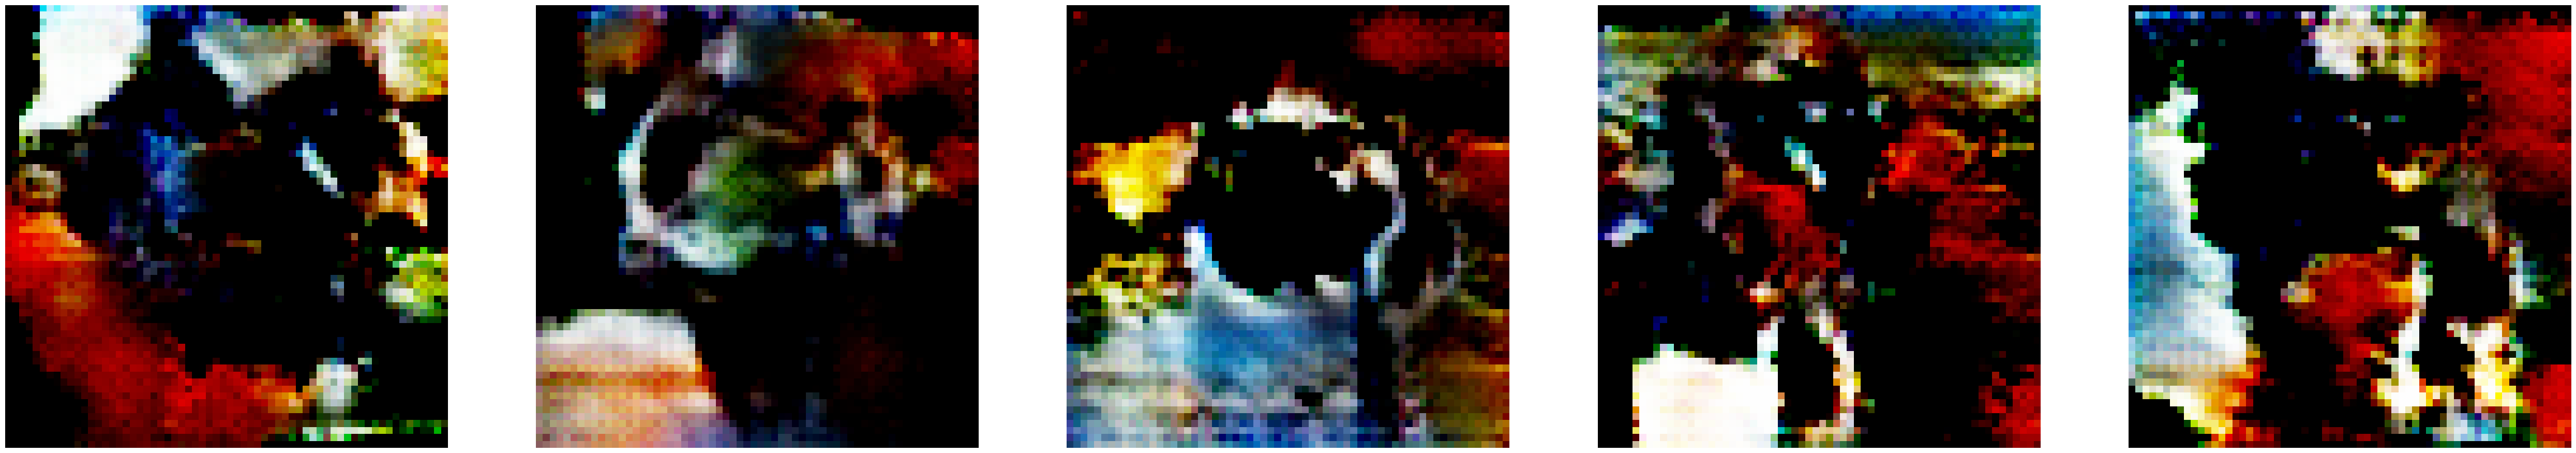

 50%|████▉     | 115/231 [02:55<02:59,  1.55s/it]

[32/50][115/231] Loss_D: 1.3580 Loss_G: 1.1596 D(x): 0.5387 D(G(z)): 0.4898 / 0.2999


100%|█████████▉| 230/231 [05:52<00:01,  1.55s/it]

[32/50][230/231] Loss_D: 1.3816 Loss_G: 0.8927 D(x): 0.4524 D(G(z)): 0.4217 / 0.4093


100%|██████████| 231/231 [05:53<00:00,  1.53s/it]


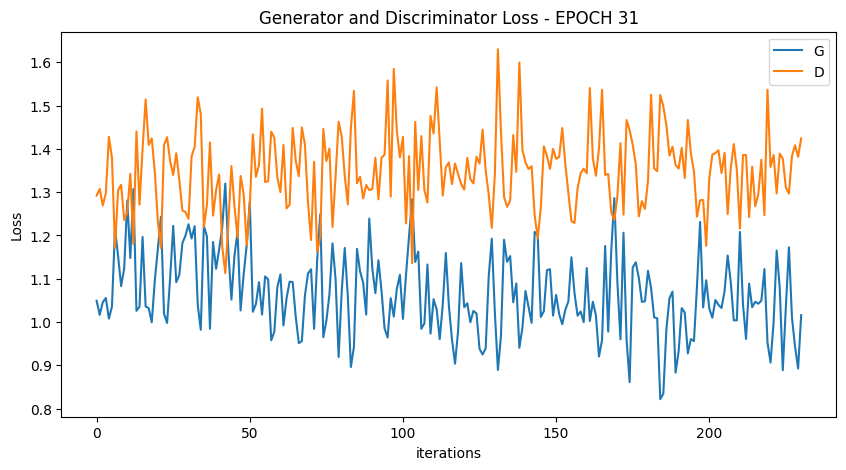

 50%|████▉     | 115/231 [02:58<03:00,  1.56s/it]

[33/50][115/231] Loss_D: 1.2915 Loss_G: 1.1609 D(x): 0.4685 D(G(z)): 0.3958 / 0.3047


100%|█████████▉| 230/231 [05:56<00:01,  1.56s/it]

[33/50][230/231] Loss_D: 1.3600 Loss_G: 1.0159 D(x): 0.4511 D(G(z)): 0.4129 / 0.3494


100%|██████████| 231/231 [05:58<00:00,  1.55s/it]


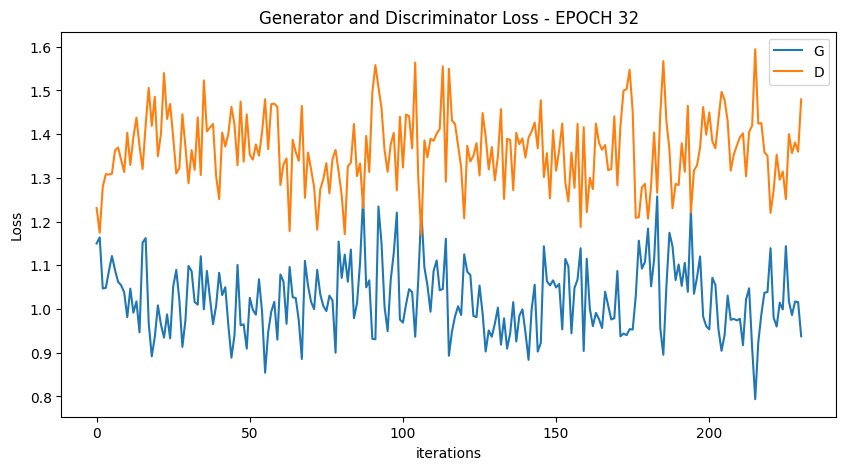

 50%|████▉     | 115/231 [02:58<03:00,  1.56s/it]

[34/50][115/231] Loss_D: 1.4310 Loss_G: 0.8580 D(x): 0.4398 D(G(z)): 0.4346 / 0.4223


100%|█████████▉| 230/231 [05:56<00:01,  1.57s/it]

[34/50][230/231] Loss_D: 1.3539 Loss_G: 1.0515 D(x): 0.3941 D(G(z)): 0.3458 / 0.3370


100%|██████████| 231/231 [05:58<00:00,  1.55s/it]


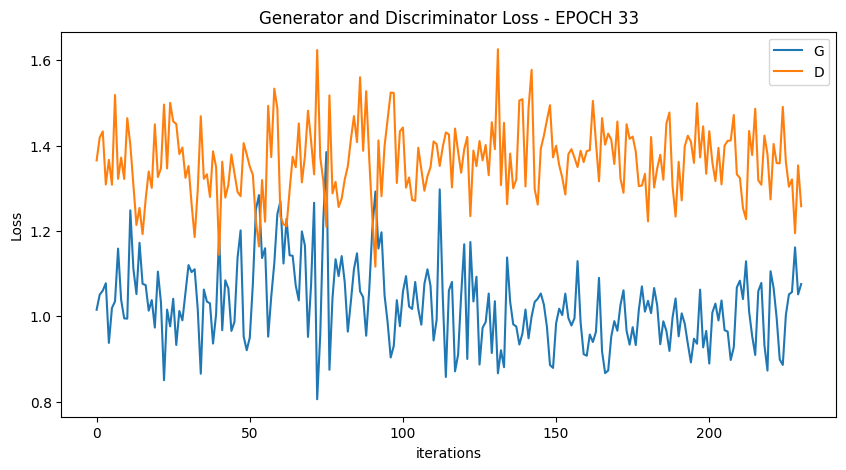

 50%|████▉     | 115/231 [02:58<03:03,  1.58s/it]

[35/50][115/231] Loss_D: 1.3044 Loss_G: 0.9858 D(x): 0.4922 D(G(z)): 0.4260 / 0.3667


100%|█████████▉| 230/231 [05:53<00:01,  1.50s/it]

[35/50][230/231] Loss_D: 1.4627 Loss_G: 0.9177 D(x): 0.3562 D(G(z)): 0.3585 / 0.3926


100%|██████████| 231/231 [05:55<00:00,  1.54s/it]


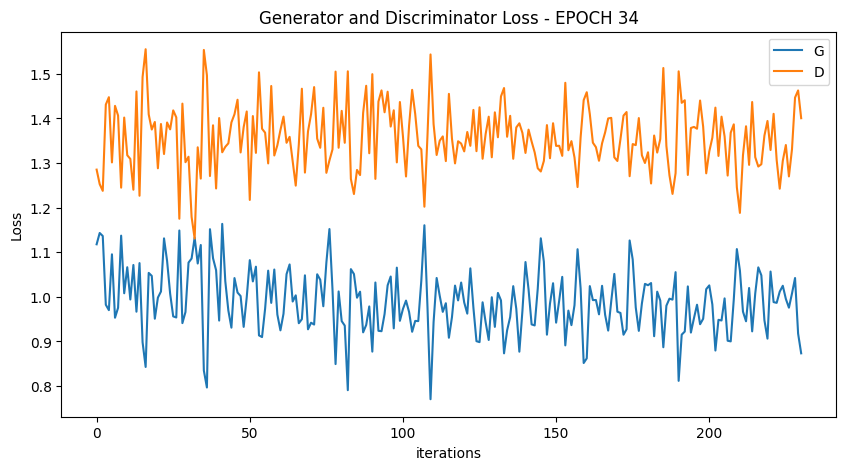

 50%|████▉     | 115/231 [02:58<02:55,  1.51s/it]

[36/50][115/231] Loss_D: 1.3156 Loss_G: 1.1415 D(x): 0.5708 D(G(z)): 0.4838 / 0.3071


100%|█████████▉| 230/231 [05:57<00:01,  1.57s/it]

[36/50][230/231] Loss_D: 1.3872 Loss_G: 0.9872 D(x): 0.4296 D(G(z)): 0.4120 / 0.3645


100%|██████████| 231/231 [05:58<00:00,  1.55s/it]


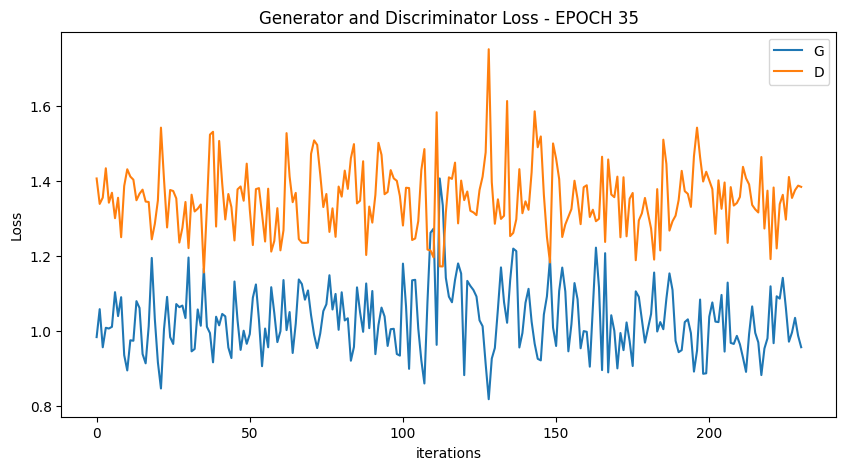

 50%|████▉     | 115/231 [03:00<03:00,  1.56s/it]

[37/50][115/231] Loss_D: 1.4093 Loss_G: 0.9877 D(x): 0.4615 D(G(z)): 0.4492 / 0.3654


100%|█████████▉| 230/231 [05:59<00:01,  1.56s/it]

[37/50][230/231] Loss_D: 1.4667 Loss_G: 0.9005 D(x): 0.4246 D(G(z)): 0.4370 / 0.4006


100%|██████████| 231/231 [06:01<00:00,  1.56s/it]


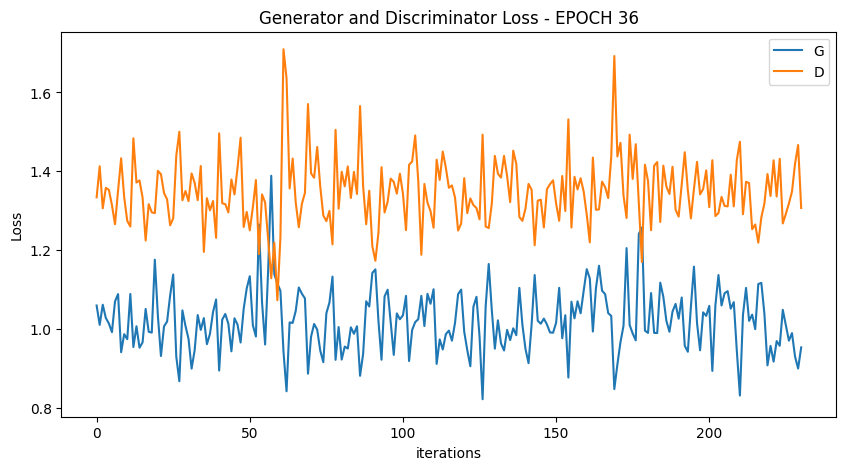

 50%|████▉     | 115/231 [02:59<03:01,  1.56s/it]

[38/50][115/231] Loss_D: 1.3595 Loss_G: 0.9618 D(x): 0.5350 D(G(z)): 0.4865 / 0.3752


100%|█████████▉| 230/231 [06:00<00:01,  1.59s/it]

[38/50][230/231] Loss_D: 1.3717 Loss_G: 0.9772 D(x): 0.4880 D(G(z)): 0.4664 / 0.3622


100%|██████████| 231/231 [06:01<00:00,  1.56s/it]


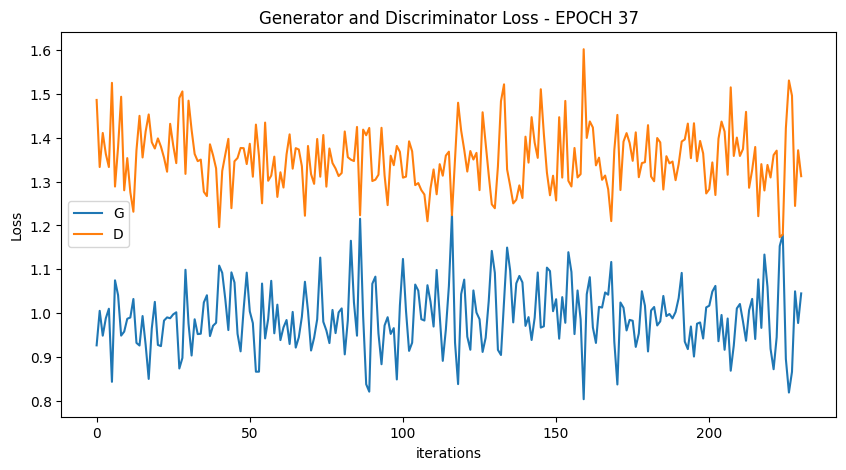

 50%|████▉     | 115/231 [03:00<03:02,  1.57s/it]

[39/50][115/231] Loss_D: 1.2794 Loss_G: 1.0309 D(x): 0.4997 D(G(z)): 0.4197 / 0.3448


100%|█████████▉| 230/231 [06:01<00:01,  1.58s/it]

[39/50][230/231] Loss_D: 1.3649 Loss_G: 1.0086 D(x): 0.4587 D(G(z)): 0.4250 / 0.3526


100%|██████████| 231/231 [06:02<00:00,  1.57s/it]


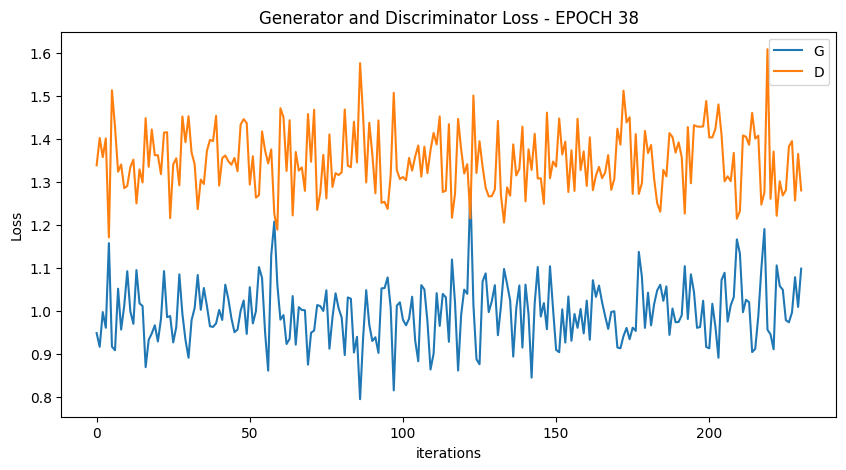

 50%|████▉     | 115/231 [03:00<03:02,  1.58s/it]

[40/50][115/231] Loss_D: 1.2722 Loss_G: 1.0531 D(x): 0.4426 D(G(z)): 0.3582 / 0.3394


100%|█████████▉| 230/231 [06:01<00:01,  1.60s/it]

[40/50][230/231] Loss_D: 1.2655 Loss_G: 0.9403 D(x): 0.4757 D(G(z)): 0.3903 / 0.3803


100%|██████████| 231/231 [06:02<00:00,  1.57s/it]


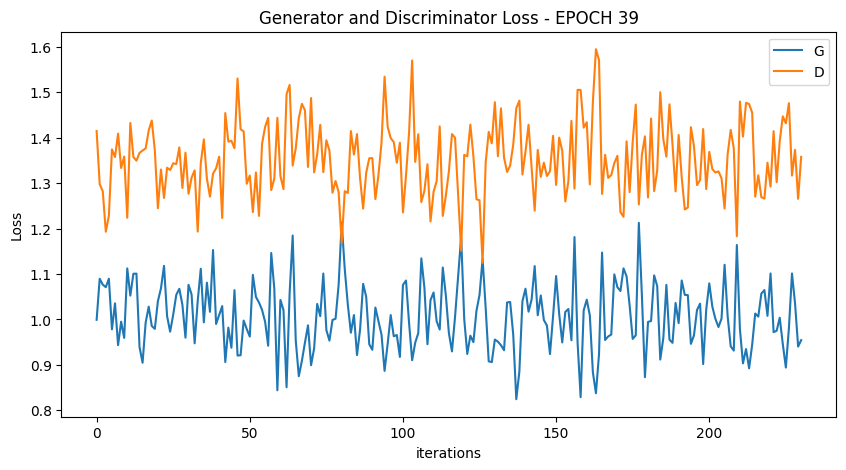

 50%|████▉     | 115/231 [03:00<03:01,  1.57s/it]

[41/50][115/231] Loss_D: 1.3194 Loss_G: 0.9875 D(x): 0.4701 D(G(z)): 0.4144 / 0.3588


100%|█████████▉| 230/231 [06:01<00:01,  1.55s/it]

[41/50][230/231] Loss_D: 1.3728 Loss_G: 0.9649 D(x): 0.4103 D(G(z)): 0.3804 / 0.3704


100%|██████████| 231/231 [06:02<00:00,  1.57s/it]


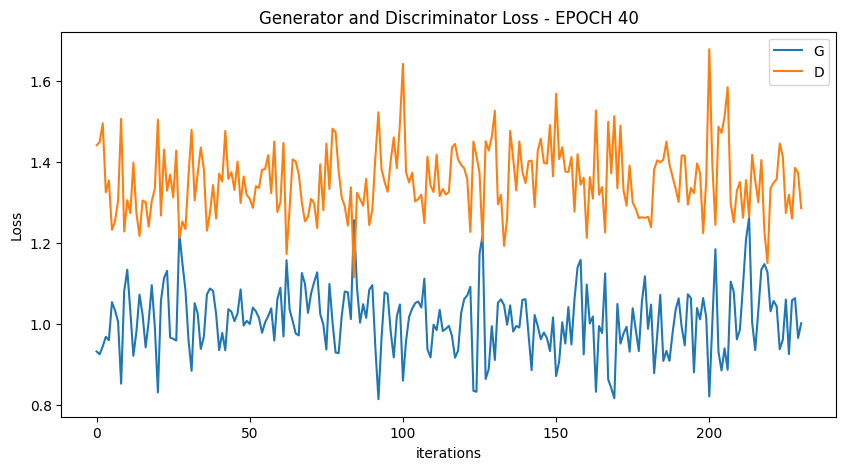

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


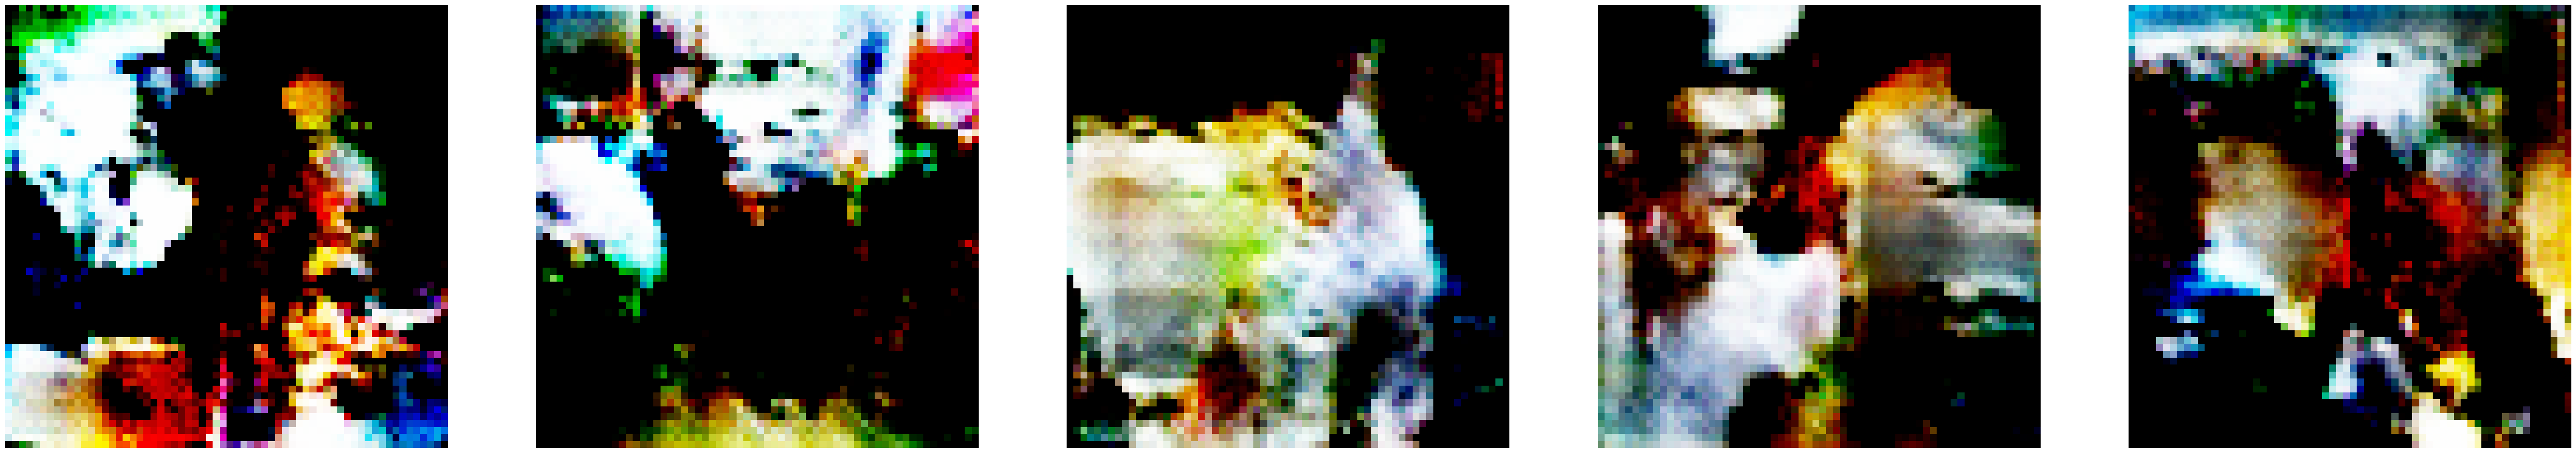

 50%|████▉     | 115/231 [03:00<03:04,  1.59s/it]

[42/50][115/231] Loss_D: 1.5297 Loss_G: 0.9378 D(x): 0.3208 D(G(z)): 0.3429 / 0.3803


100%|█████████▉| 230/231 [06:01<00:01,  1.55s/it]

[42/50][230/231] Loss_D: 1.2911 Loss_G: 1.0740 D(x): 0.5795 D(G(z)): 0.4923 / 0.3240


100%|██████████| 231/231 [06:02<00:00,  1.57s/it]


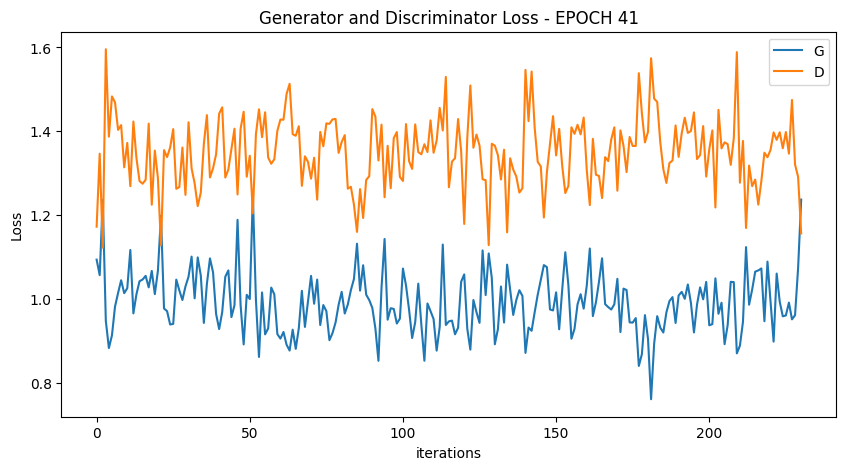

 50%|████▉     | 115/231 [02:59<02:59,  1.55s/it]

[43/50][115/231] Loss_D: 1.3130 Loss_G: 0.9782 D(x): 0.5200 D(G(z)): 0.4529 / 0.3653


100%|█████████▉| 230/231 [05:57<00:01,  1.55s/it]

[43/50][230/231] Loss_D: 1.4110 Loss_G: 0.9566 D(x): 0.4333 D(G(z)): 0.4289 / 0.3761


100%|██████████| 231/231 [05:59<00:00,  1.55s/it]


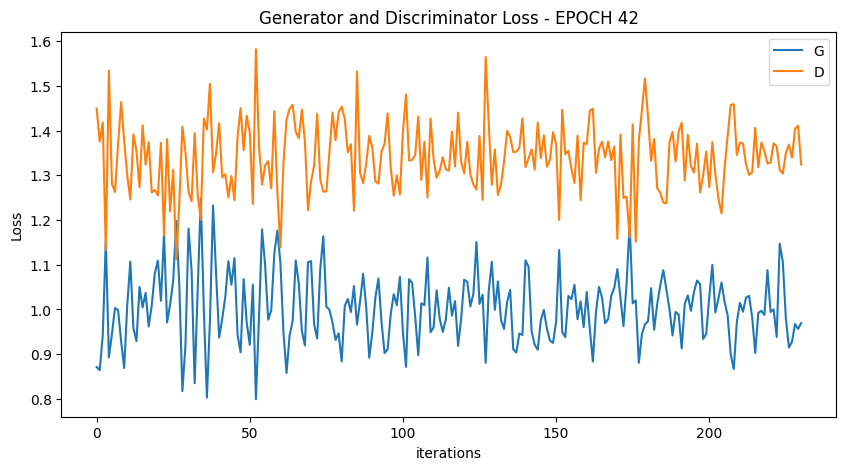

 50%|████▉     | 115/231 [02:57<03:02,  1.58s/it]

[44/50][115/231] Loss_D: 1.3407 Loss_G: 1.0492 D(x): 0.4458 D(G(z)): 0.4022 / 0.3357


100%|█████████▉| 230/231 [05:54<00:01,  1.54s/it]

[44/50][230/231] Loss_D: 1.3195 Loss_G: 1.0337 D(x): 0.4817 D(G(z)): 0.4327 / 0.3451


100%|██████████| 231/231 [05:56<00:00,  1.54s/it]


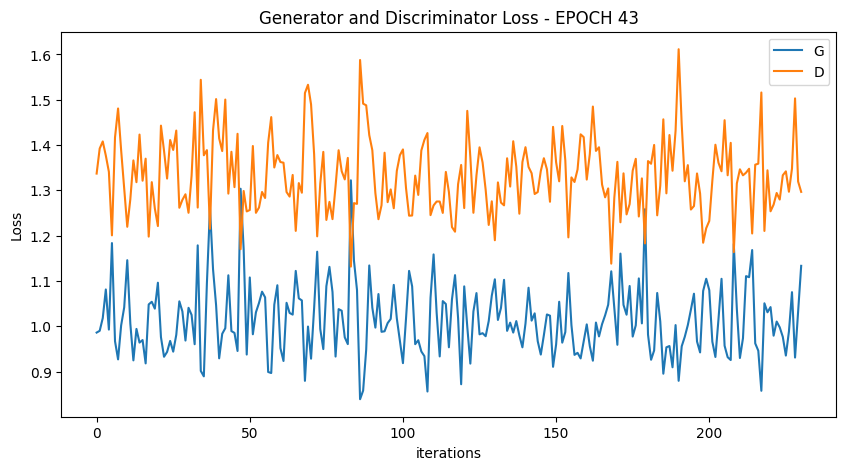

 50%|████▉     | 115/231 [02:57<02:56,  1.52s/it]

[45/50][115/231] Loss_D: 1.2415 Loss_G: 1.0703 D(x): 0.4409 D(G(z)): 0.3334 / 0.3281


100%|█████████▉| 230/231 [05:54<00:01,  1.52s/it]

[45/50][230/231] Loss_D: 1.2867 Loss_G: 1.0892 D(x): 0.5428 D(G(z)): 0.4618 / 0.3195


100%|██████████| 231/231 [05:55<00:00,  1.54s/it]


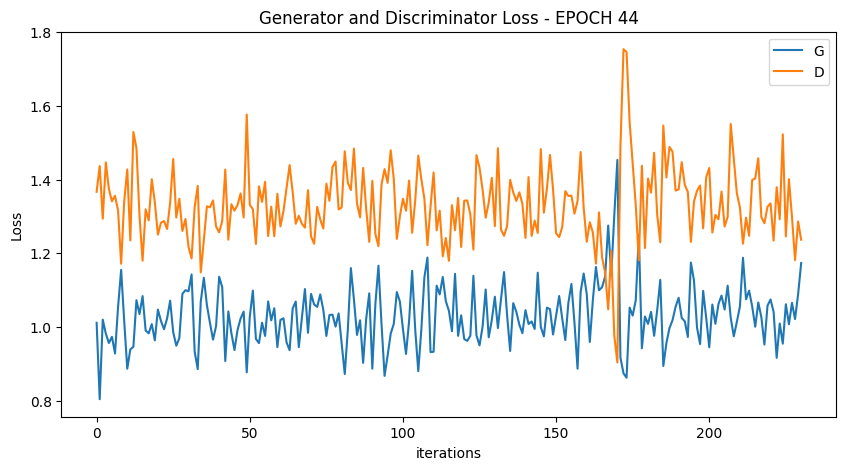

 50%|████▉     | 115/231 [02:55<03:00,  1.56s/it]

[46/50][115/231] Loss_D: 1.4056 Loss_G: 0.9533 D(x): 0.4290 D(G(z)): 0.4218 / 0.3753


100%|█████████▉| 230/231 [05:49<00:01,  1.52s/it]

[46/50][230/231] Loss_D: 1.2607 Loss_G: 1.1004 D(x): 0.5156 D(G(z)): 0.4250 / 0.3189


100%|██████████| 231/231 [05:51<00:00,  1.52s/it]


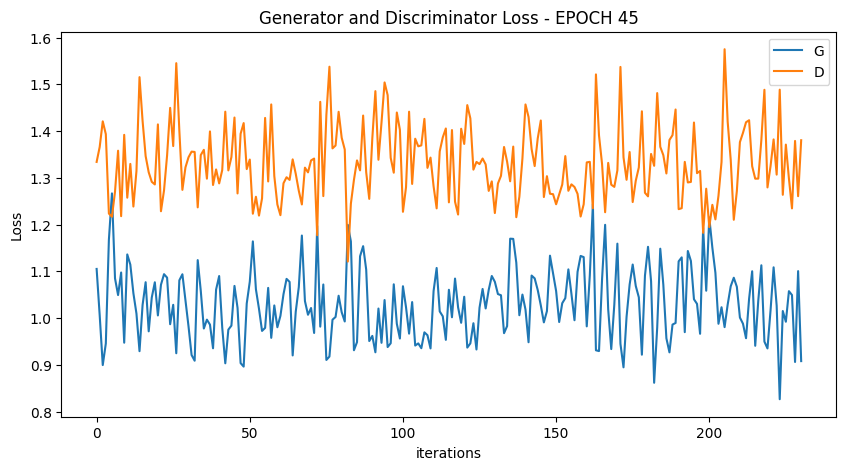

 50%|████▉     | 115/231 [02:56<02:56,  1.52s/it]

[47/50][115/231] Loss_D: 1.3165 Loss_G: 0.9757 D(x): 0.4849 D(G(z)): 0.4287 / 0.3733


100%|█████████▉| 230/231 [05:52<00:01,  1.52s/it]

[47/50][230/231] Loss_D: 1.3110 Loss_G: 1.0118 D(x): 0.4758 D(G(z)): 0.4208 / 0.3471


100%|██████████| 231/231 [05:53<00:00,  1.53s/it]


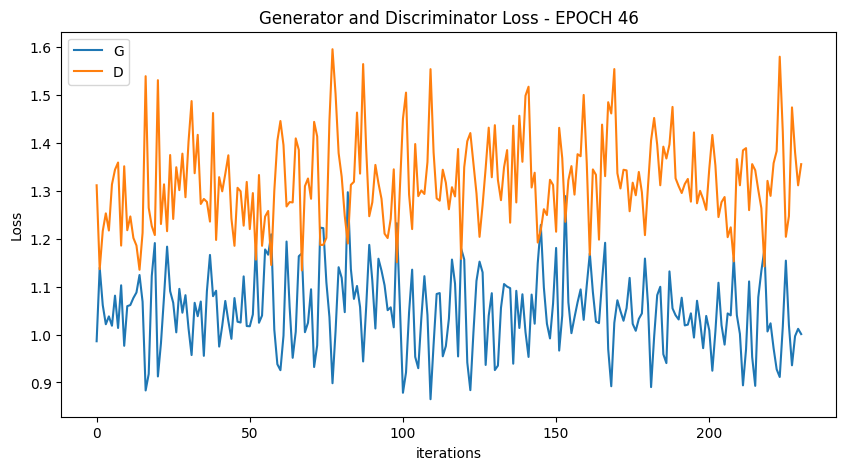

 50%|████▉     | 115/231 [02:55<02:51,  1.48s/it]

[48/50][115/231] Loss_D: 1.2321 Loss_G: 1.0631 D(x): 0.4404 D(G(z)): 0.3212 / 0.3343


100%|█████████▉| 230/231 [05:52<00:01,  1.52s/it]

[48/50][230/231] Loss_D: 1.4128 Loss_G: 0.9109 D(x): 0.4661 D(G(z)): 0.4579 / 0.3959


100%|██████████| 231/231 [05:54<00:00,  1.53s/it]


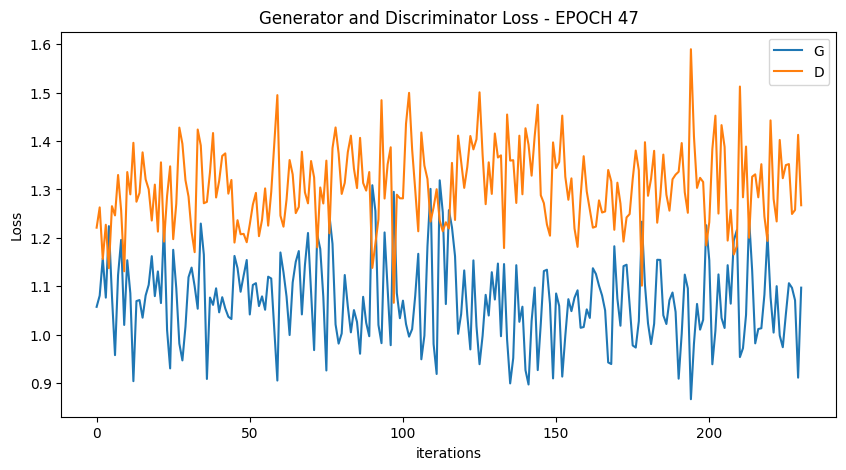

 50%|████▉     | 115/231 [02:53<02:52,  1.49s/it]

[49/50][115/231] Loss_D: 1.2424 Loss_G: 1.1159 D(x): 0.4742 D(G(z)): 0.3743 / 0.3099


100%|█████████▉| 230/231 [05:16<00:01,  1.19s/it]

[49/50][230/231] Loss_D: 1.4766 Loss_G: 1.0377 D(x): 0.3973 D(G(z)): 0.4134 / 0.3384


100%|██████████| 231/231 [05:17<00:00,  1.37s/it]


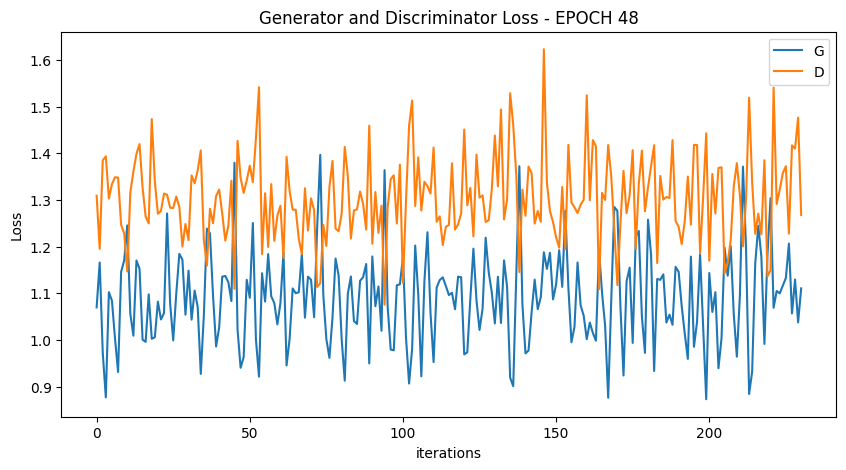

 50%|████▉     | 115/231 [02:01<01:49,  1.05it/s]

[50/50][115/231] Loss_D: 1.3219 Loss_G: 1.1606 D(x): 0.4656 D(G(z)): 0.4065 / 0.3058


100%|█████████▉| 230/231 [04:08<00:01,  1.10s/it]

[50/50][230/231] Loss_D: 1.3383 Loss_G: 0.9867 D(x): 0.4861 D(G(z)): 0.4332 / 0.3656


100%|██████████| 231/231 [04:09<00:00,  1.08s/it]


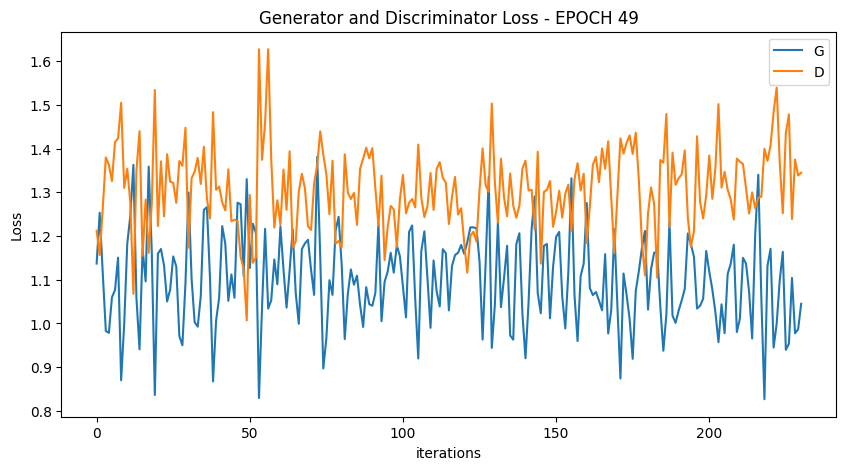

In [54]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        #Обновление сети D: максимизация log(D(x)) + log(1 - D(G(z)))
        #С реальными данными
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        #С фейковыми
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        #Обновление сети G: максимизация log(D(G(z)))
        netG.zero_grad()
        labels.fill_(real_label)  
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        #Сохранение потерь для построения графиков
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)

In [55]:
print ("Average EPOCH duration = ", np.mean(epoch_time))

Average EPOCH duration =  308.2730422735214


# Вывод сгенерированных изображений

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


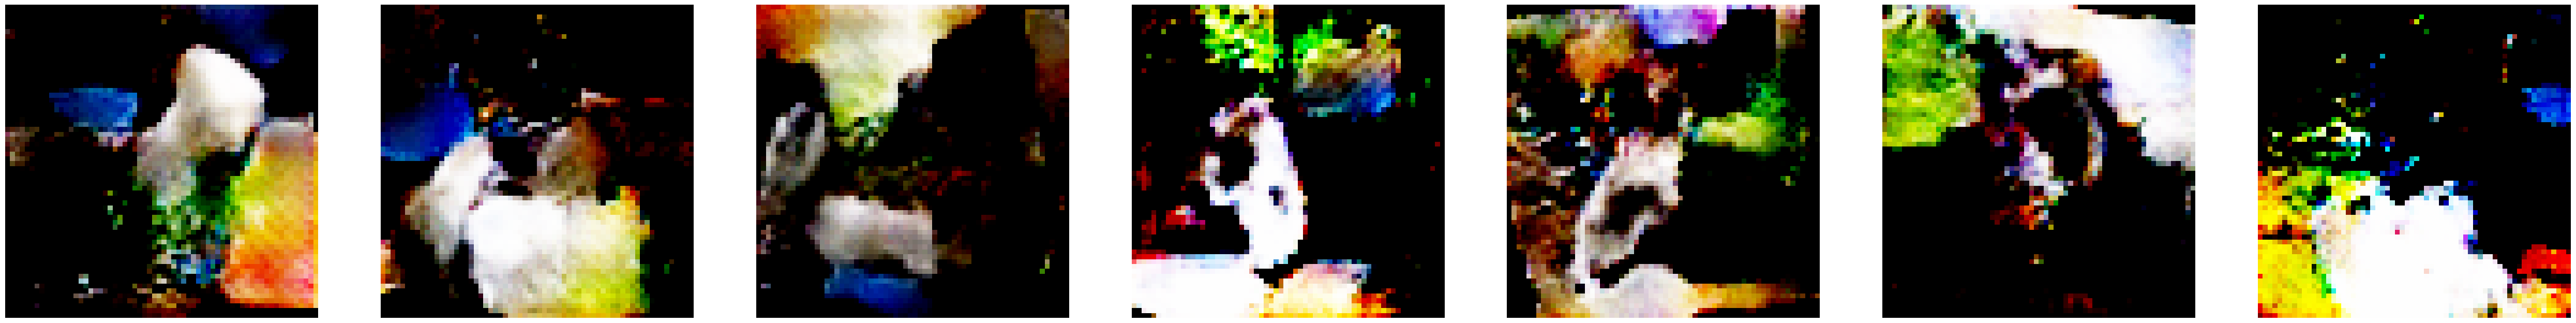

In [56]:
show_generated_img(7)

In [57]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
    
im_batch_size = 50
n_images=10000

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))

100%|██████████| 200/200 [01:44<00:00,  1.92it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

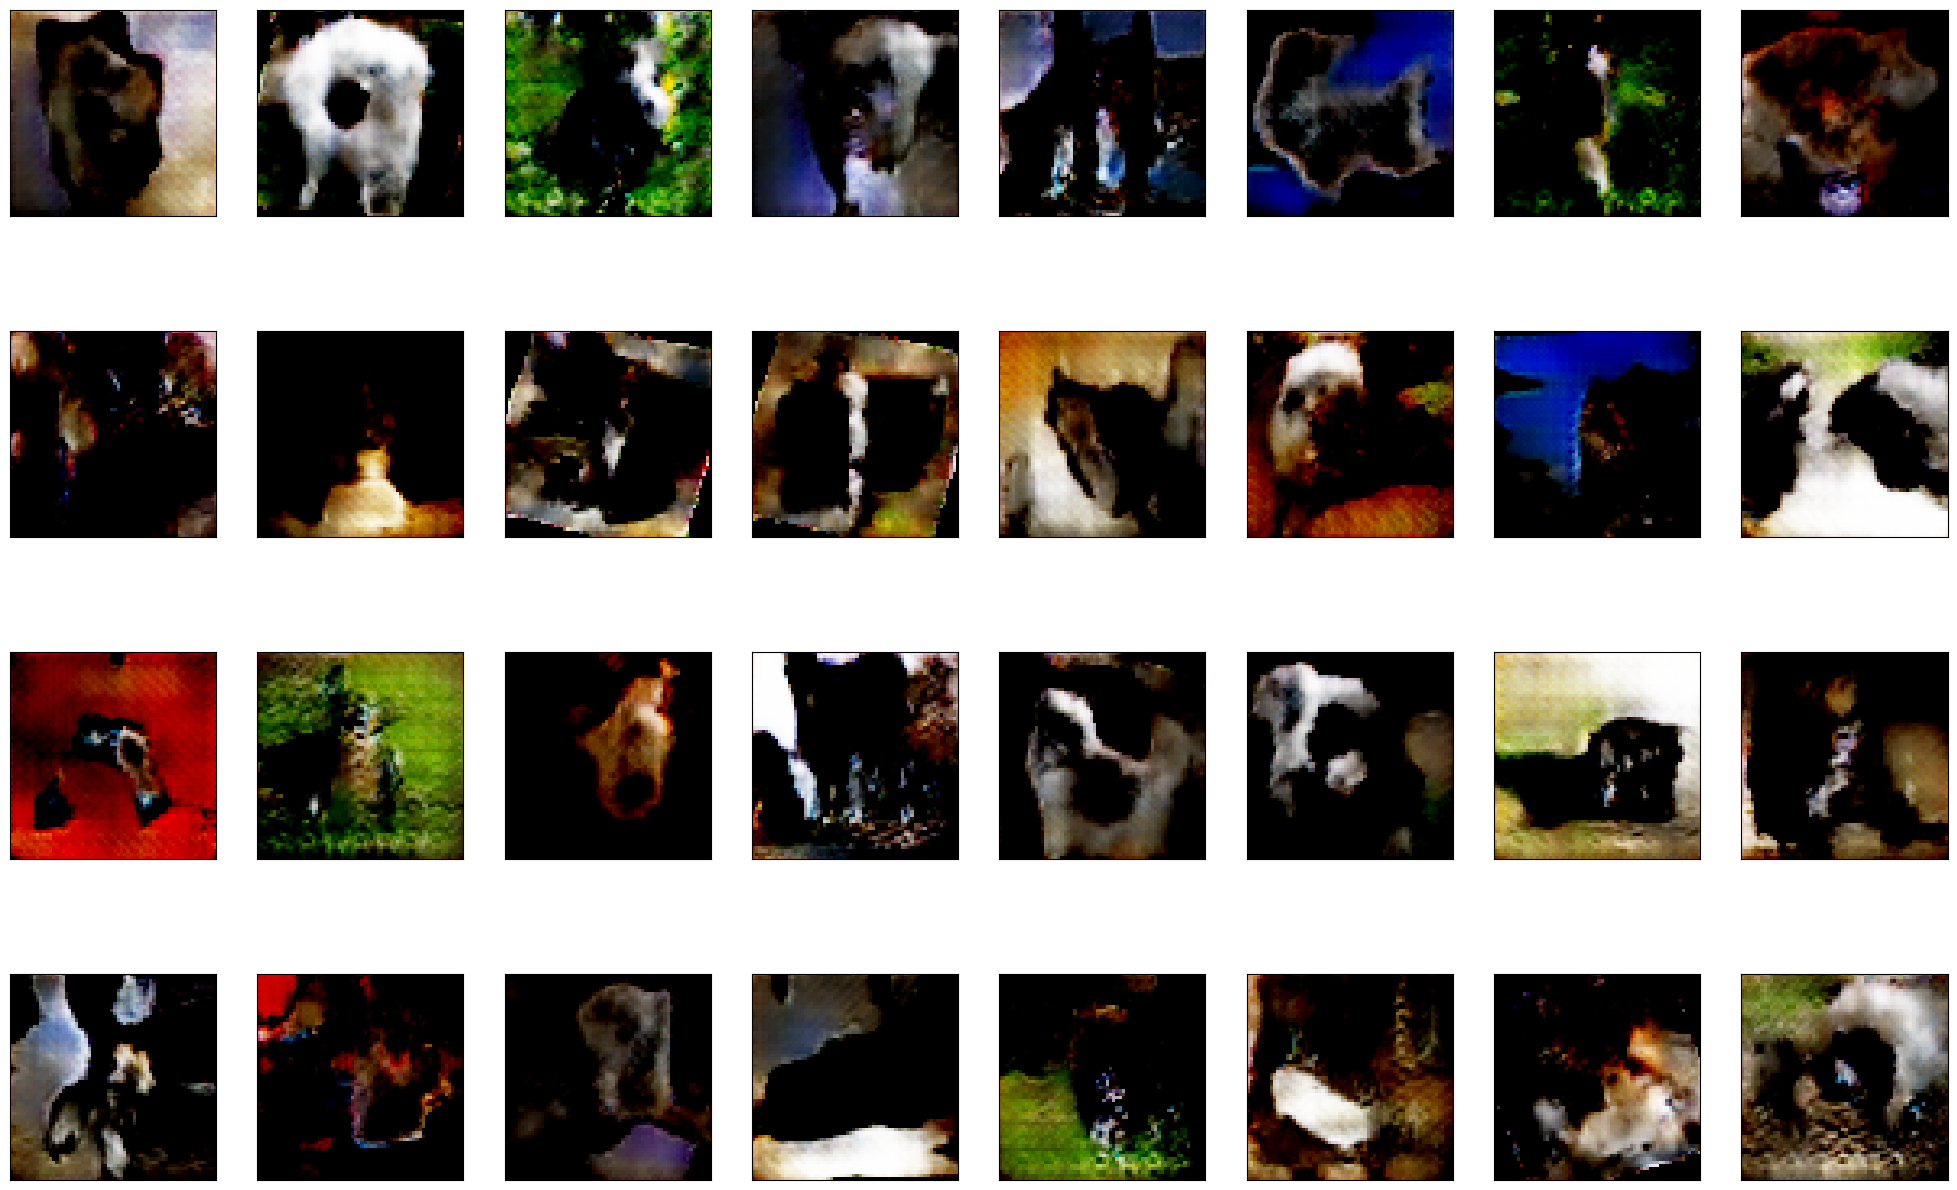

In [58]:
fig = plt.figure(figsize=(25, 16))
#10 изображений из каждого класса
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)